# Experiment 7

Coordination game with a bottleneck and Polya urn pairing

In [ ]:
Two optimization approaches:
1. Policy gradients
2. Gumbel-softmax relaxation

In [1]:
import random

import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from egg import core
from egg.zoo.simple_autoenc.features import OneHotLoader
from egg.zoo.simple_autoenc.archs import Sender
from egg.zoo.simple_autoenc.train import get_params

In [2]:
opts = core.init(params=['--random_seed=7', 
                         '--n_epochs=50',
                         '--batch_size=10'])
opts.n_features = 10
opts.batches_per_epoch = 1000
opts.sender_entropy_coeff = 0.01
opts.receiver_entropy_coeff = 0.01
opts.alphabet_size = 8
opts.sender_population_size = 3
opts.receiver_population_size = 3
opts.lr = 1e-2

In [3]:
def loss(sender_input, _message, _receiver_input, receiver_output, _labels):
    acc = (receiver_output == sender_input.argmax(dim=1)).detach().float().mean(dim=0)
    return -acc, {'acc': acc.item()}

train_loader = OneHotLoader(n_features=opts.n_features, batch_size=opts.batch_size,
                            batches_per_epoch=opts.batches_per_epoch)
test_loader = OneHotLoader(n_features=opts.n_features, batch_size=opts.batch_size,
                            batches_per_epoch=opts.batches_per_epoch, seed=7)

class Receiver(nn.Module):
    def __init__(self, n_hidden, n_features):
        super(Receiver, self).__init__()
        self.output = core.RelaxedEmbedding(n_hidden, n_features)

    def forward(self, x, _input):
        return self.output(x)

senders = [core.ReinforceWrapper(Sender(opts.alphabet_size, opts.n_features)) 
           for _ in range(opts.sender_population_size)]
receivers = [core.ReinforceWrapper(Receiver(opts.n_features, opts.alphabet_size)) 
             for _ in range(opts.receiver_population_size)]
for i, sender in enumerate(senders):
    sender.receiver_preference = torch.ones(len(receivers))
    sender.id = i
for i, receiver in enumerate(receivers):
    receiver.id = i

In [4]:
class MultiAgentGame(nn.Module):

    def __init__(self, senders, receivers, loss, sender_entropy_coeff=opts.sender_entropy_coeff, receiver_entropy_coeff=opts.sender_entropy_coeff):
        super(MultiAgentGame, self).__init__()
        self.senders = senders
        self.receivers = receivers
        self.loss = loss

        self.receiver_entropy_coeff = receiver_entropy_coeff
        self.sender_entropy_coeff = sender_entropy_coeff

        self.mean_baseline = 0.0
        self.n_points = 0.0

    def forward(self, sender_input, labels, receiver_input=None):
        sender = np.random.choice(senders)
        distribution_over_receivers = torch.distributions.Categorical(logits=sender.receiver_preference)
        receiver_id = distribution_over_receivers.sample().item()
        receiver = receivers[receiver_id]
        sender.receiver_preference[receiver_id] += 1
        message, sender_log_prob, sender_entropy = sender(sender_input)
        receiver_output, receiver_log_prob, receiver_entropy = receiver(message, receiver_input)

        loss, rest_info = self.loss(sender_input, message, receiver_input, receiver_output, labels)
        policy_loss = ((loss.detach() - self.mean_baseline) * (sender_log_prob + receiver_log_prob)).mean()
        entropy_loss = -(sender_entropy.mean() * self.sender_entropy_coeff + receiver_entropy.mean() * self.receiver_entropy_coeff)

        if self.training:
            self.n_points += 1.0
            self.mean_baseline += (loss.detach().mean().item() -
                                   self.mean_baseline) / self.n_points

        full_loss = policy_loss + entropy_loss + loss.mean()

        rest_info['baseline'] = self.mean_baseline
        rest_info['loss'] = loss.mean().item()
        rest_info['sender_entropy'] = sender_entropy.mean()
        rest_info['receiver_entropy'] = receiver_entropy.mean()
        rest_info['sender preference entropy'] = distribution_over_receivers.entropy()
        return full_loss, rest_info

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import neptune
from neptune.experiments import Experiment


class NeptuneMonitor:
        
    def __init__(self, experiment: Experiment = None):
        self.experiment = experiment if experiment else neptune
    
    def log(self, mode, epoch, loss, rest):
        self.experiment.send_metric(f'{mode}_loss', loss)
        for metric, value in rest.items():
            self.experiment.send_metric(f'{mode}_{metric}', value)

            
def save_sender_codebook(experiment, senders, epoch):
    figure, axes = plt.subplots(1,len(receivers),sharey=True, figsize=(20,5))
    figure.suptitle(f'Epoch {epoch}')
    for i, (sender, ax) in enumerate(zip(senders, axes)):
        g = sns.heatmap(F.softmax(sender.agent.fc1.weight.detach(), dim=0).numpy(), annot=True, fmt='.2f', ax=ax)
        g.set_title(f'Sender {i}')
    figure.savefig('fig.jpg')
    experiment.log_image('senders', 'fig.jpg')

    
def save_preference(experiment, senders, epoch):
    figure, axes = plt.subplots(1,len(senders),sharey=True, figsize=(20,5))
    figure.suptitle(f'Sender\'s preference for receivers, epoch {epoch}')
    for i, sender in enumerate(senders):
        g = sns.barplot(np.arange(3), sender.receiver_preference.detach().numpy(), ax=axes[i])
        g.set_title(f'Sender {i}')
    figure.savefig('fig_senders.jpg')
    experiment.log_image('senders_pererence', 'fig_senders.jpg')
    figure.close()

In [12]:
class CustomTrainer(core.Trainer):

    def train(self, n_epochs):
        while self.epoch < n_epochs:
            train_loss, train_rest = self.train_epoch()

            self.epoch += 1

            self.monitor.log('train', self.epoch, train_loss, train_rest)
            

            if self.validation_data is not None and self.validation_freq > 0 and self.epoch % self.validation_freq == 0:
                validation_loss, rest = self.eval()
                self.monitor.log('validation', self.epoch, validation_loss, rest)
                print(f'validation: epoch {self.epoch}, loss {validation_loss},  {rest}', flush=True)
                save_sender_codebook(self.monitor.experiment, self.game.senders, self.epoch)
                save_preference(self.monitor.experiment, self.game.senders, self.epoch)

                if self.early_stopping:
                    self.early_stopping.update_values(validation_loss, rest, train_loss, rest, self.epoch)
                    if self.early_stopping.should_stop(): break

EGG-31
https://ui.neptune.ml/tomekkorbak/egg/e/EGG-31
validation: epoch 1, loss -0.13490895926952362,  {'acc': 0.14900000298768282, 'baseline': -0.13180000268667694, 'loss': -0.14900000298768282, 'sender_entropy': tensor(1.8891), 'receiver_entropy': tensor(1.7791), 'sender preference entropy': tensor(0.)}


/Users/tomek/.virtualenvs/x/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


validation: epoch 2, loss -0.1148202121257782,  {'acc': 0.1766000038012862, 'baseline': -0.14310000305995405, 'loss': -0.1766000038012862, 'sender_entropy': tensor(1.7885), 'receiver_entropy': tensor(1.7350), 'sender preference entropy': tensor(0.)}
validation: epoch 3, loss -0.07612264901399612,  {'acc': 0.24890000522136688, 'baseline': -0.16926667030652298, 'loss': -0.24890000522136688, 'sender_entropy': tensor(1.5870), 'receiver_entropy': tensor(1.4966), 'sender preference entropy': tensor(0.)}
validation: epoch 4, loss -0.06351625919342041,  {'acc': 0.34590000634640455, 'baseline': -0.19987500426731916, 'loss': -0.34590000634640455, 'sender_entropy': tensor(1.3411), 'receiver_entropy': tensor(1.2230), 'sender preference entropy': tensor(0.)}
validation: epoch 5, loss -0.11373558640480042,  {'acc': 0.39990000607073306, 'baseline': -0.23450000473409477, 'loss': -0.39990000607073306, 'sender_entropy': tensor(1.1892), 'receiver_entropy': tensor(1.0364), 'sender preference entropy': ten

/Users/tomek/.virtualenvs/x/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


validation: epoch 12, loss -0.5013841390609741,  {'acc': 0.6611000036895275, 'baseline': -0.426375004896897, 'loss': -0.6611000036895275, 'sender_entropy': tensor(0.6116), 'receiver_entropy': tensor(0.3276), 'sender preference entropy': tensor(0.)}
validation: epoch 13, loss -0.5506600141525269,  {'acc': 0.6829000018984079, 'baseline': -0.4455923123869677, 'loss': -0.6829000018984079, 'sender_entropy': tensor(0.5573), 'receiver_entropy': tensor(0.2412), 'sender preference entropy': tensor(0.)}
validation: epoch 14, loss -0.5825491547584534,  {'acc': 0.6955000022947788, 'baseline': -0.4636500044960023, 'loss': -0.6955000022947788, 'sender_entropy': tensor(0.5410), 'receiver_entropy': tensor(0.1912), 'sender preference entropy': tensor(0.)}
validation: epoch 15, loss -0.5985043048858643,  {'acc': 0.7037000017315149, 'baseline': -0.47893333769689755, 'loss': -0.7037000017315149, 'sender_entropy': tensor(0.5389), 'receiver_entropy': tensor(0.1670), 'sender preference entropy': tensor(0.)}


validation: epoch 45, loss -0.7870022654533386,  {'acc': 0.7992999966740608, 'baseline': -0.6758911112700717, 'loss': -0.7992999966740608, 'sender_entropy': tensor(0.3655), 'receiver_entropy': tensor(0.0025), 'sender preference entropy': tensor(0.)}
validation: epoch 46, loss -0.7884183526039124,  {'acc': 0.7996999967694283, 'baseline': -0.678567391408026, 'loss': -0.7996999967694283, 'sender_entropy': tensor(0.3706), 'receiver_entropy': tensor(0.0023), 'sender preference entropy': tensor(0.)}
validation: epoch 47, loss -0.7886331081390381,  {'acc': 0.7997999968528747, 'baseline': -0.6810000000381988, 'loss': -0.7997999968528747, 'sender_entropy': tensor(0.3697), 'receiver_entropy': tensor(0.0021), 'sender preference entropy': tensor(0.)}
validation: epoch 48, loss -0.7906330823898315,  {'acc': 0.7996999968290329, 'baseline': -0.6835249999750602, 'loss': -0.7996999968290329, 'sender_entropy': tensor(0.3630), 'receiver_entropy': tensor(0.0020), 'sender preference entropy': tensor(0.)}
v

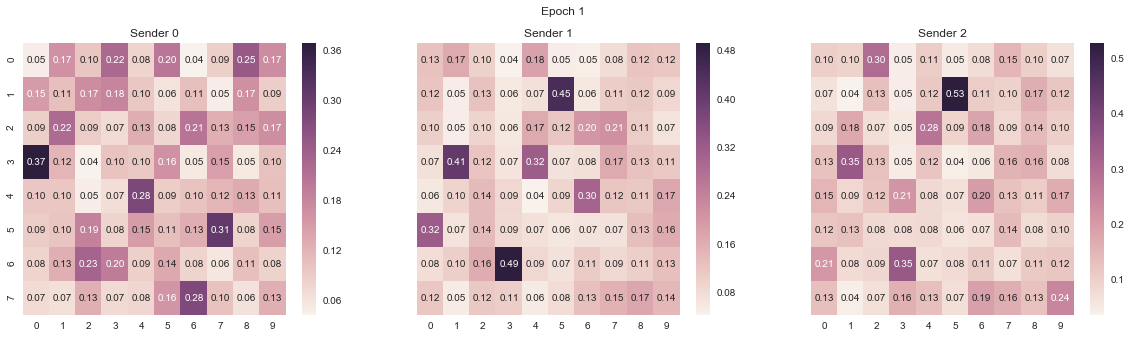

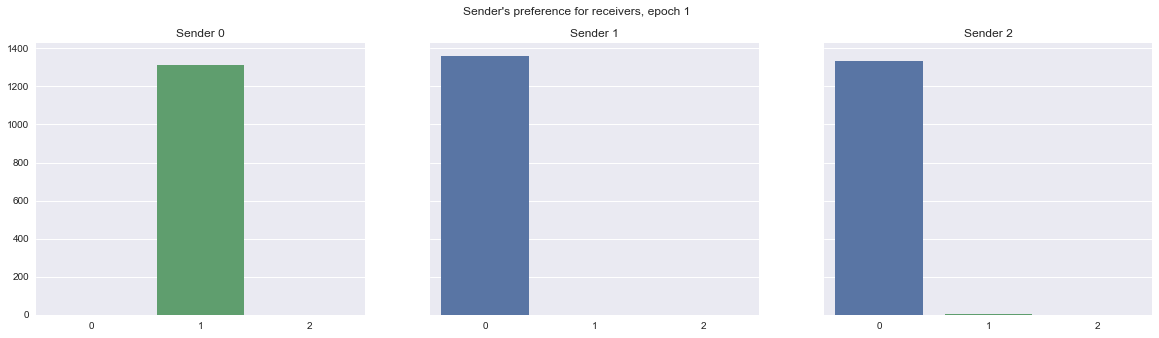

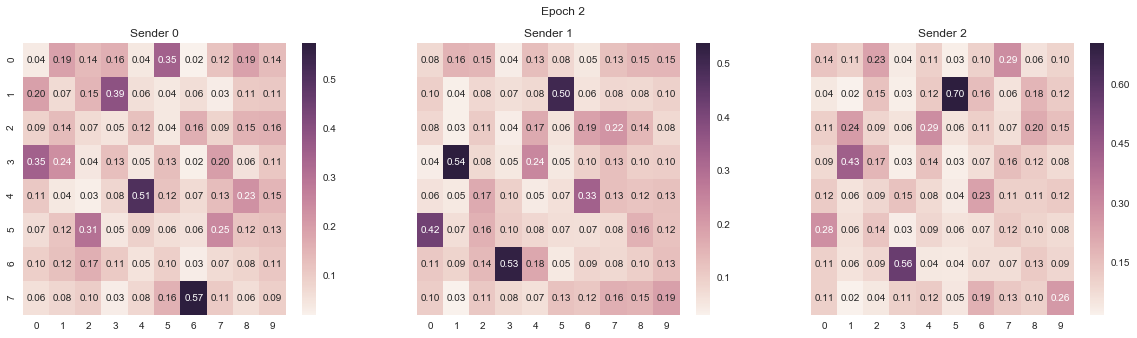

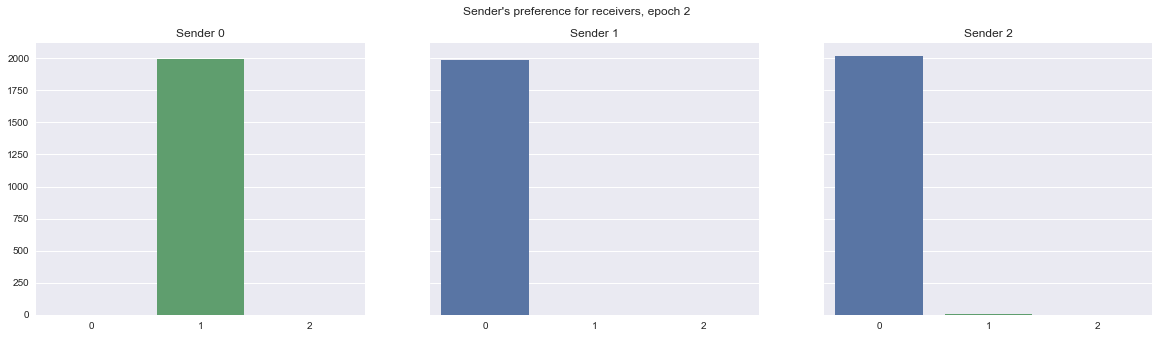

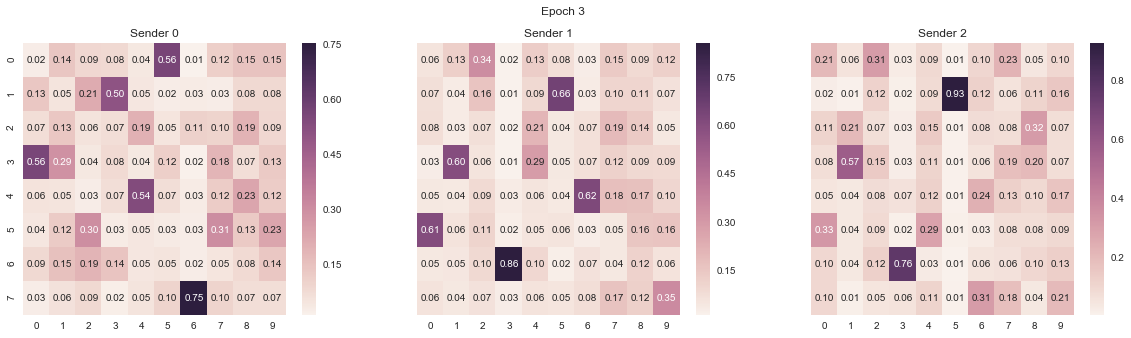

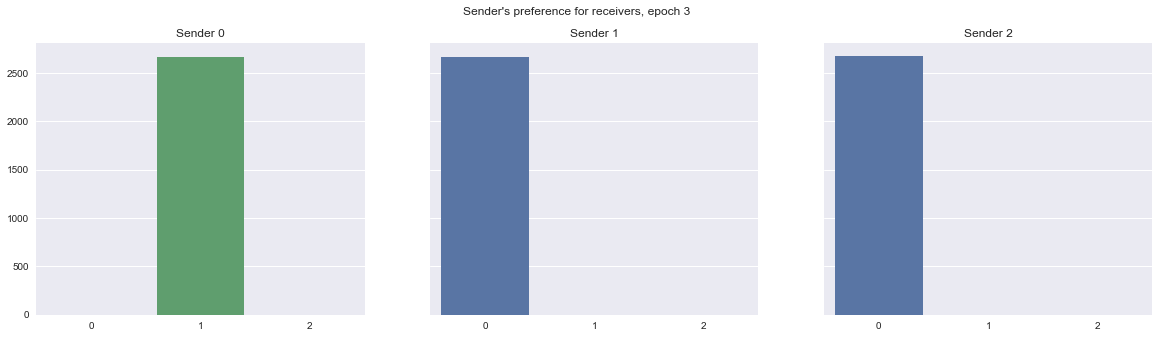

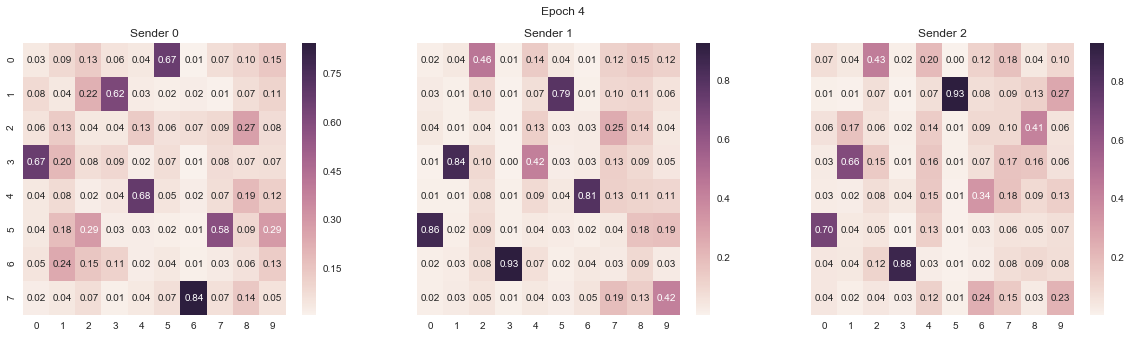

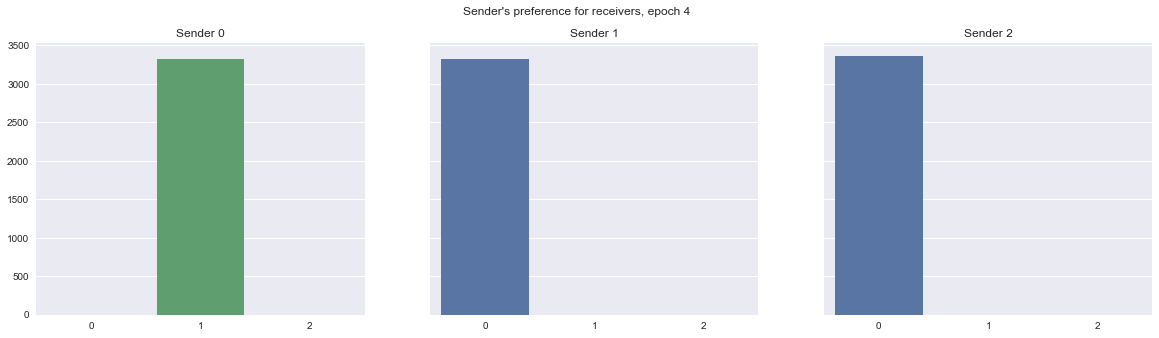

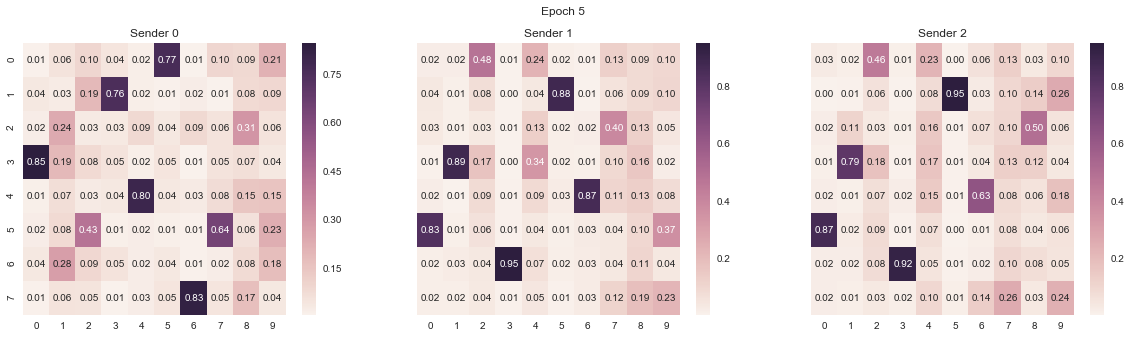

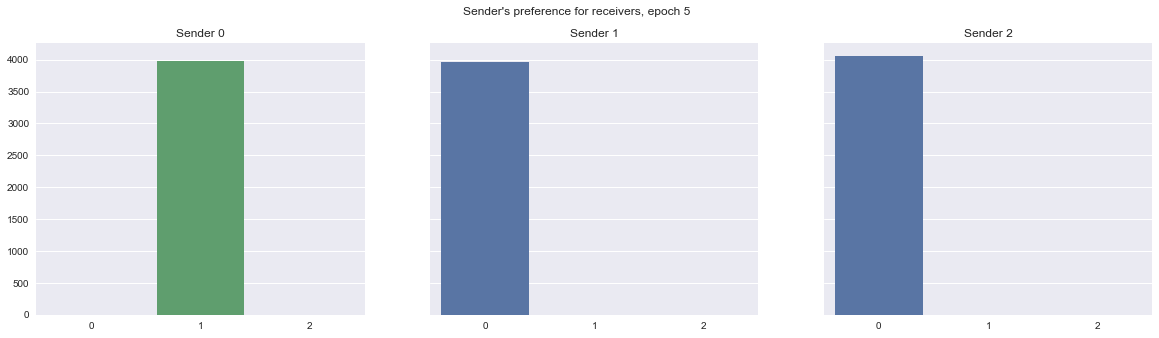

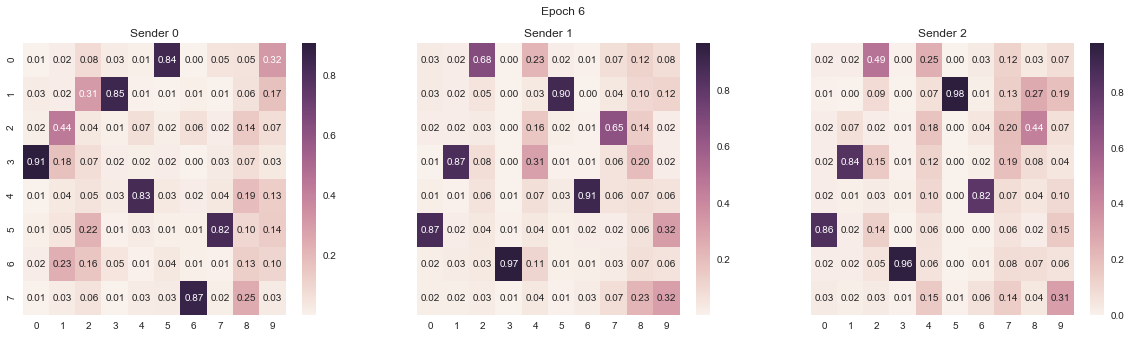

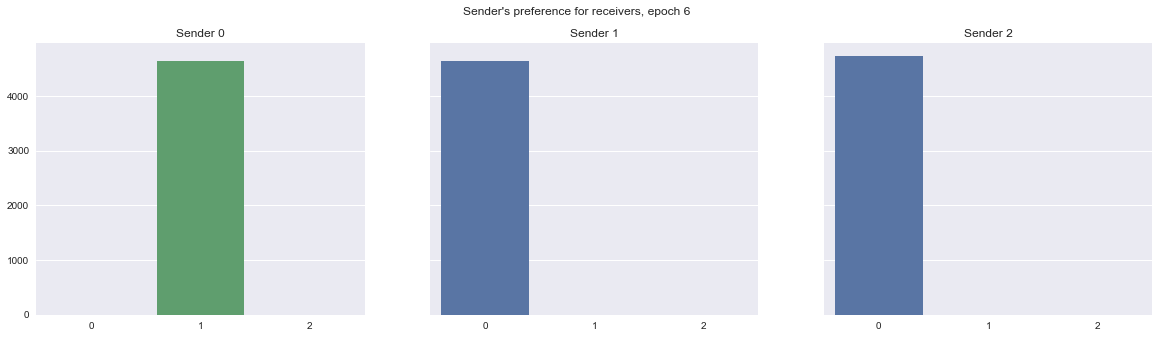

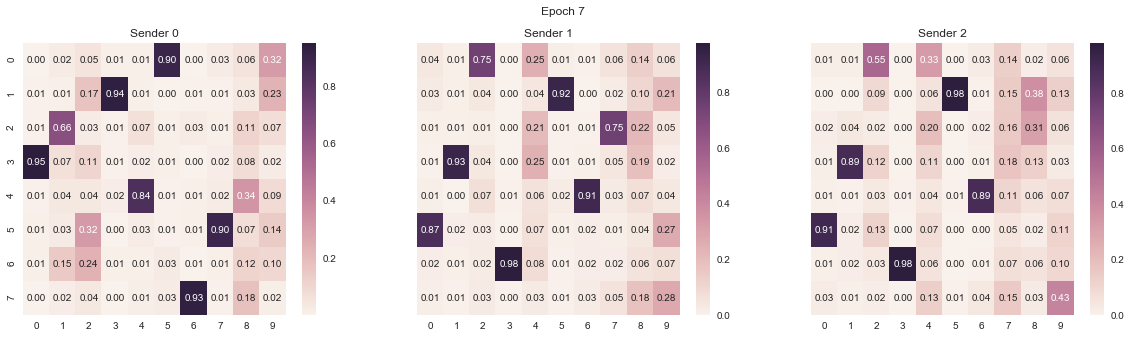

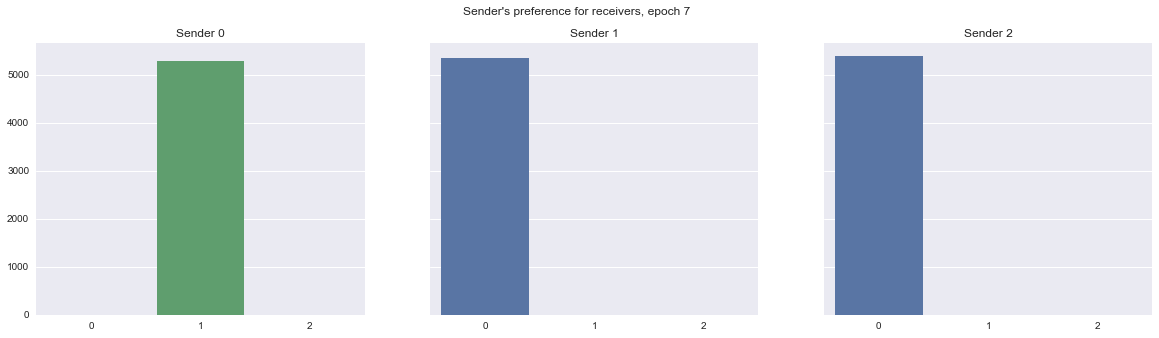

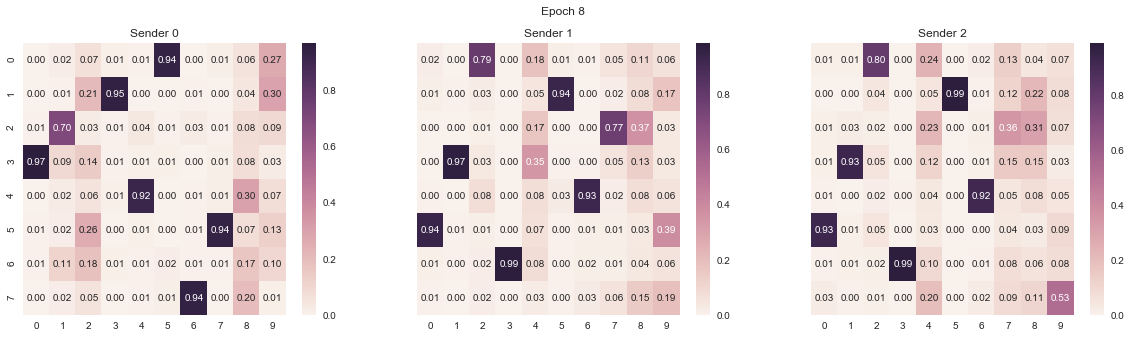

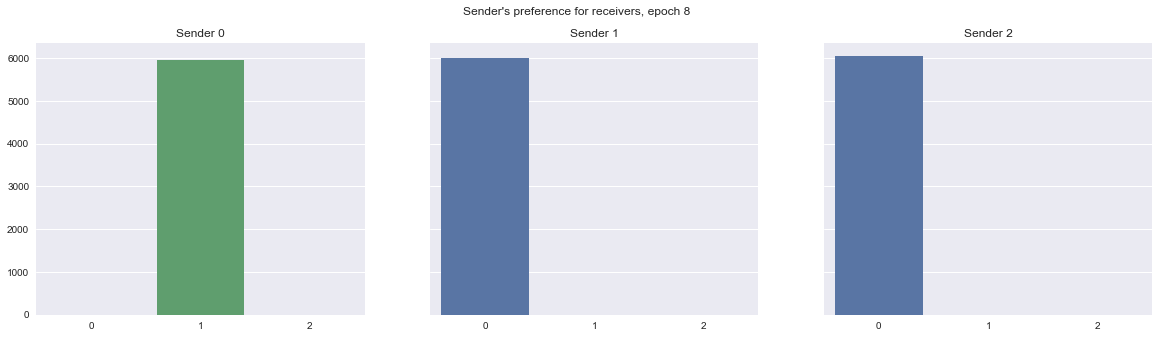

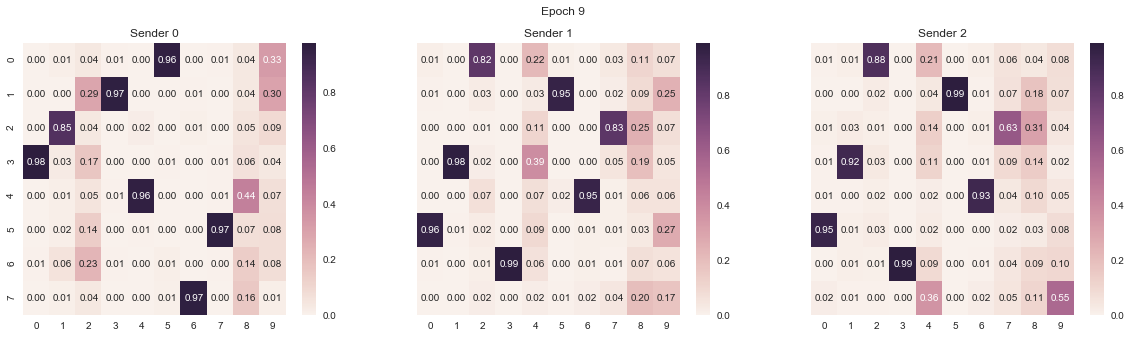

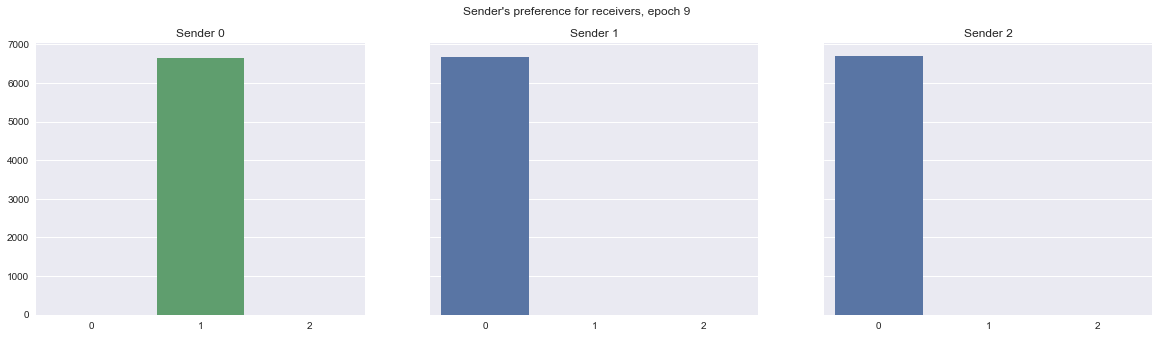

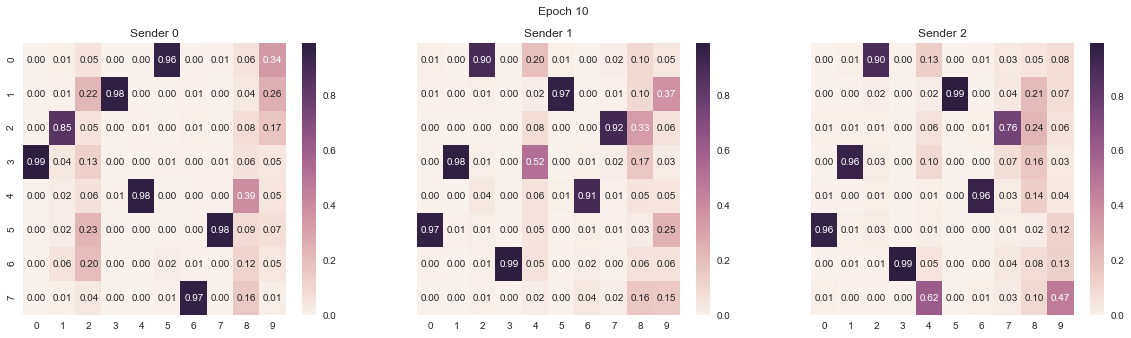

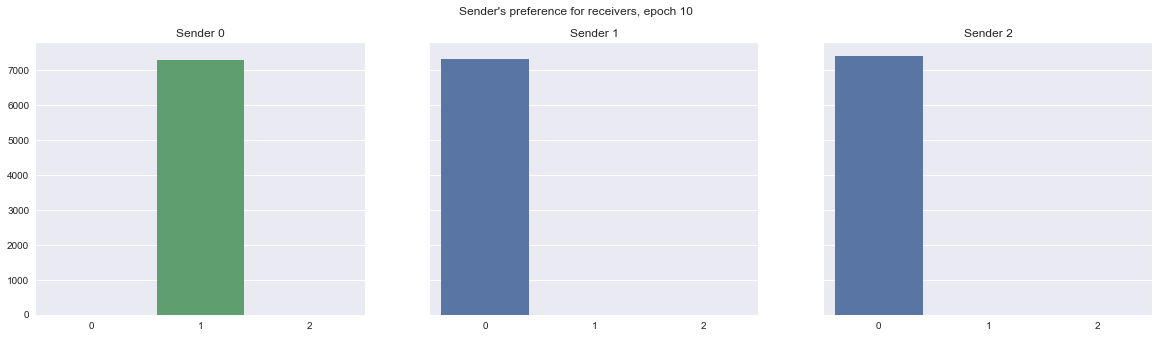

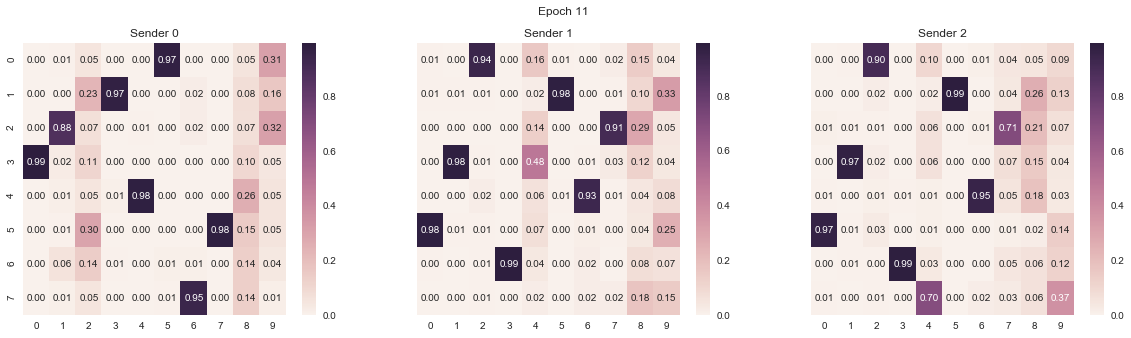

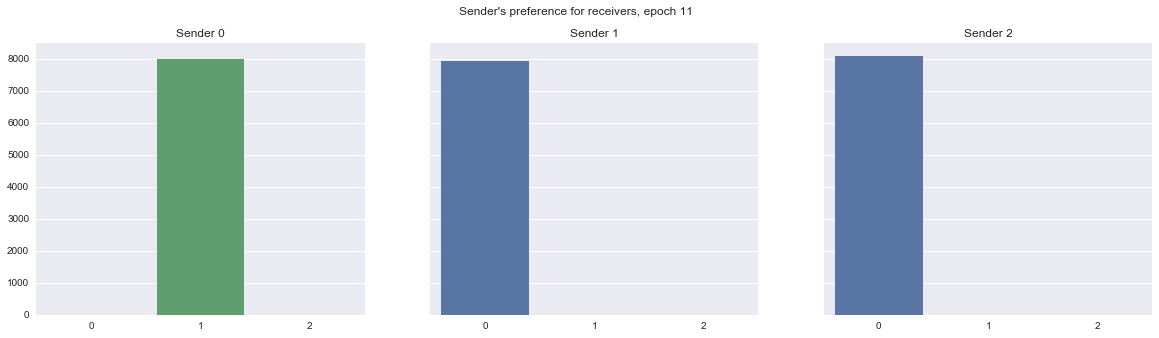

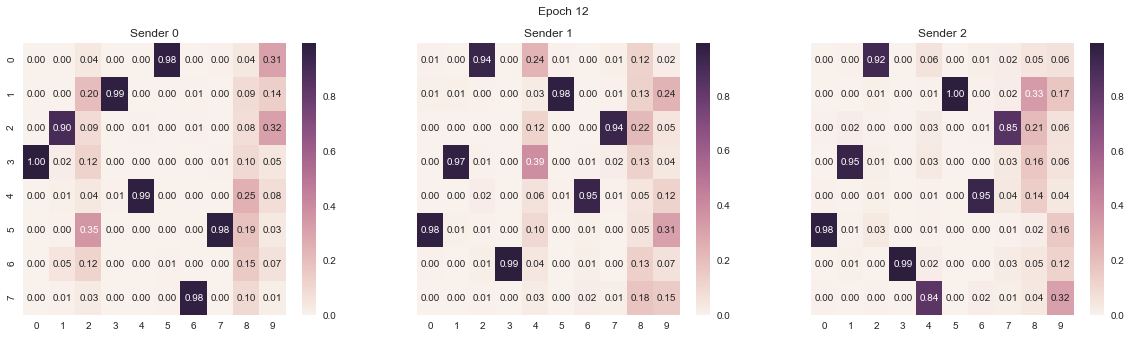

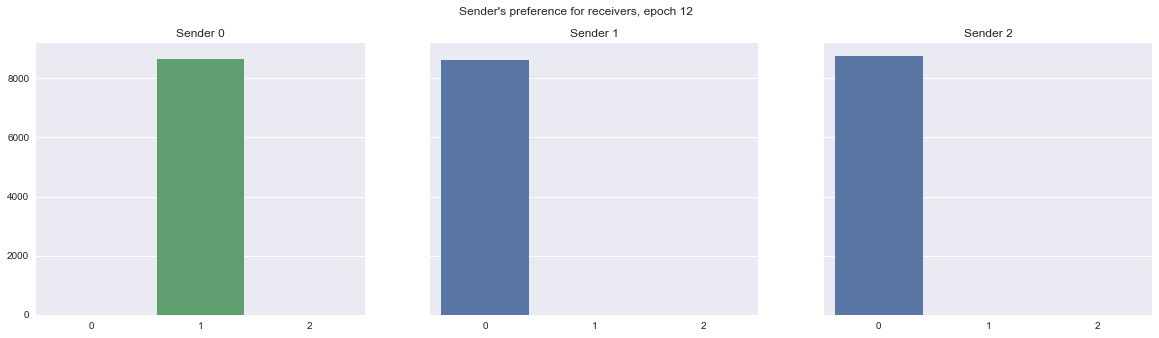

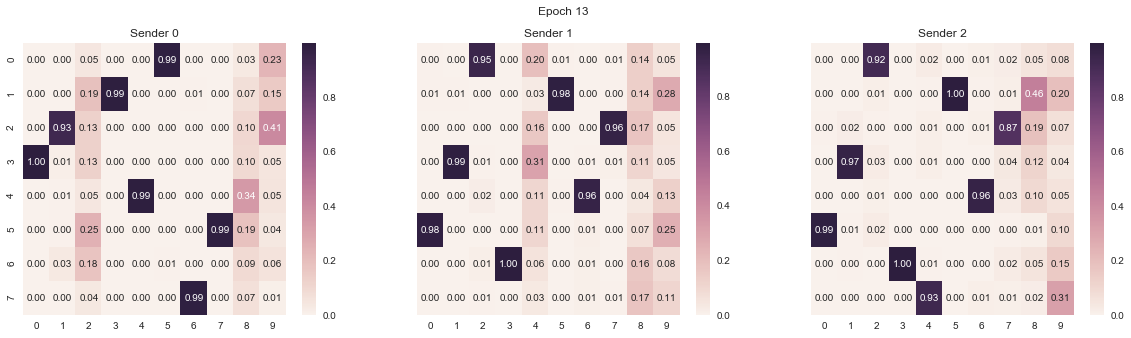

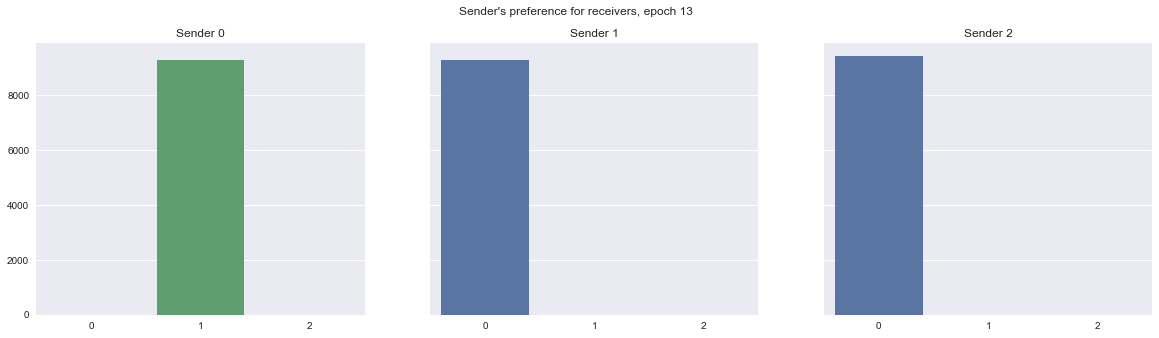

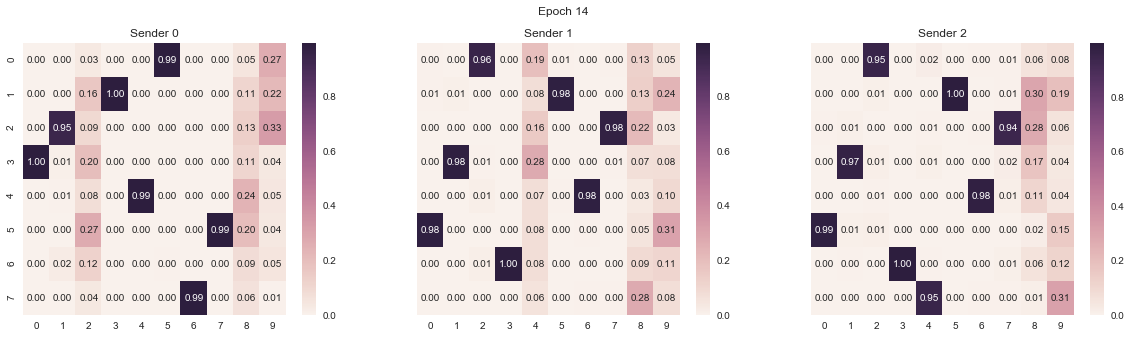

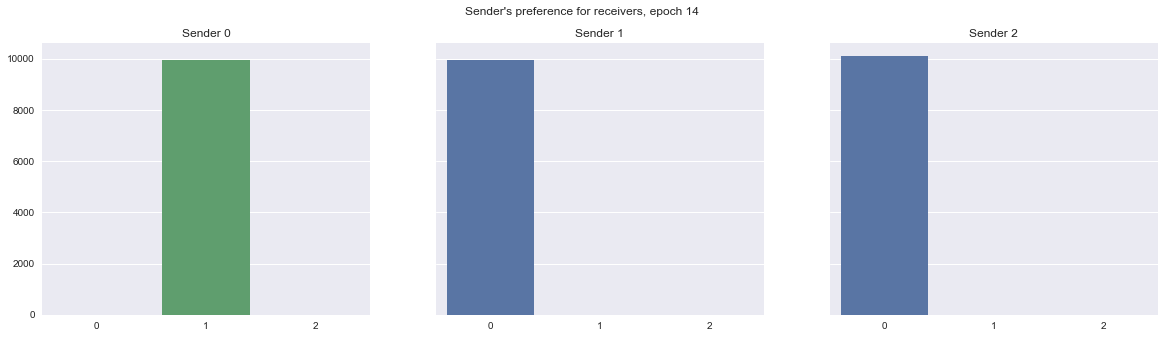

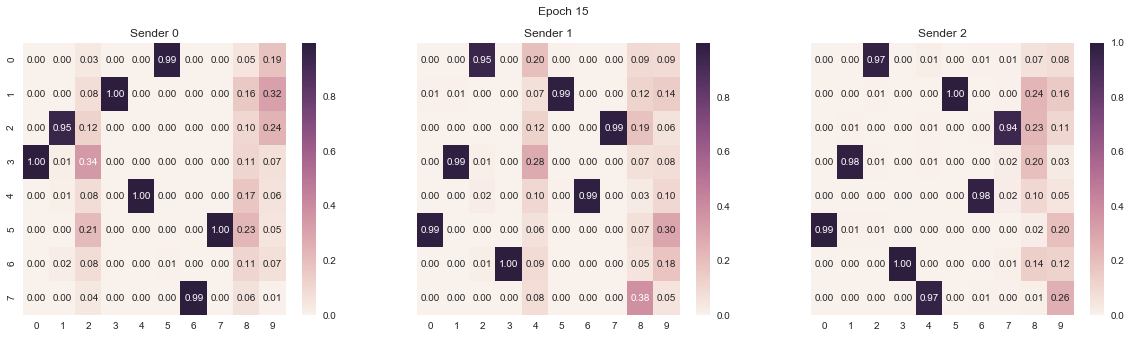

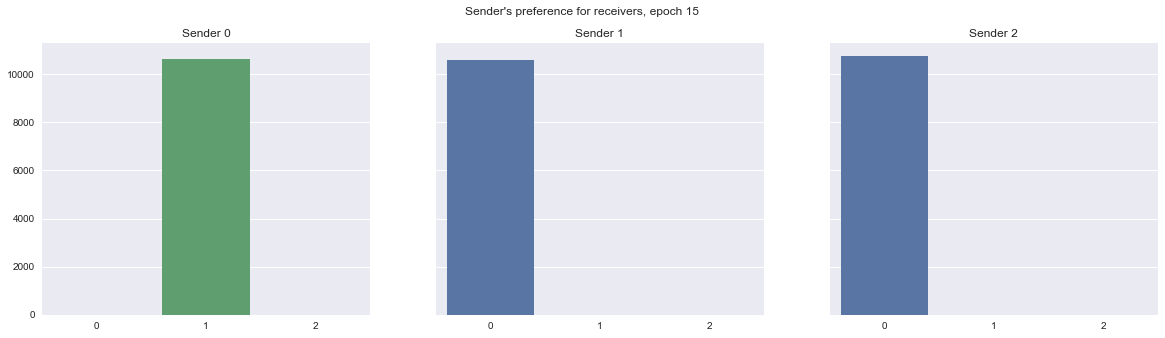

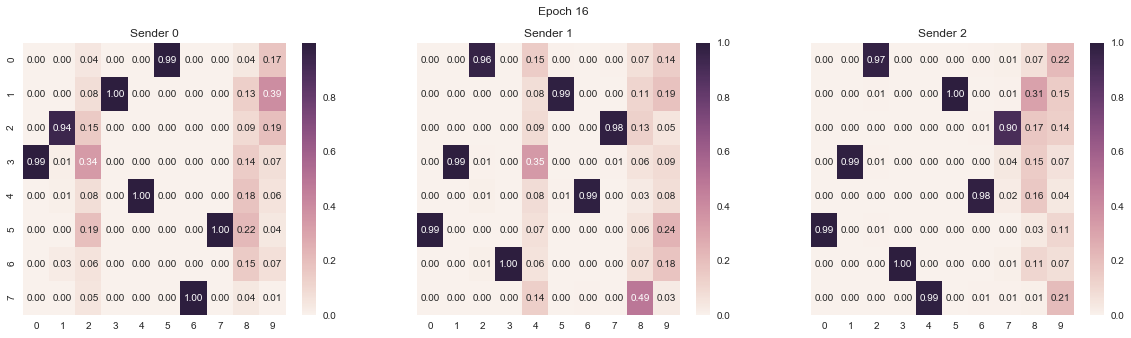

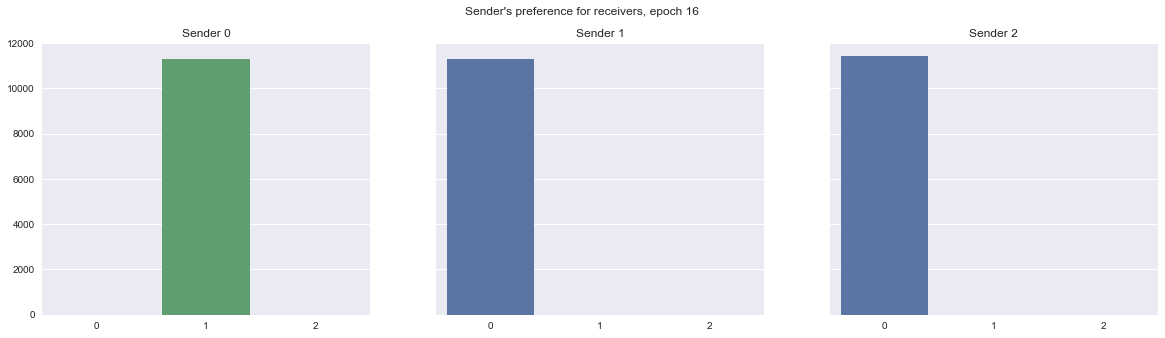

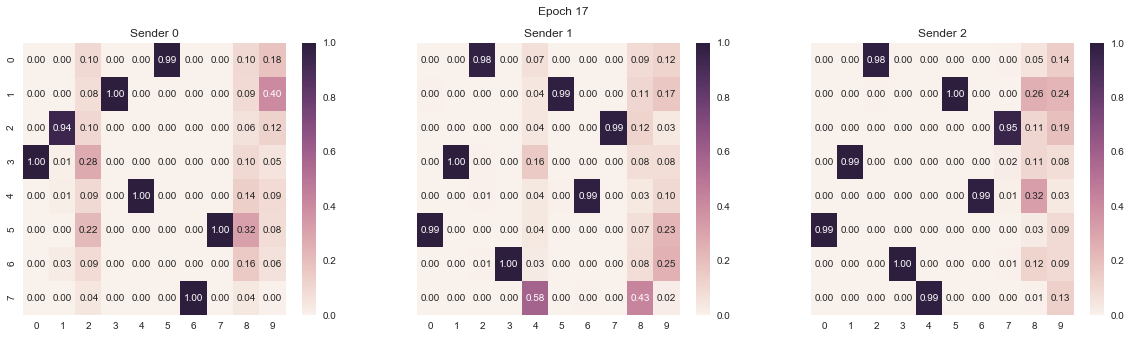

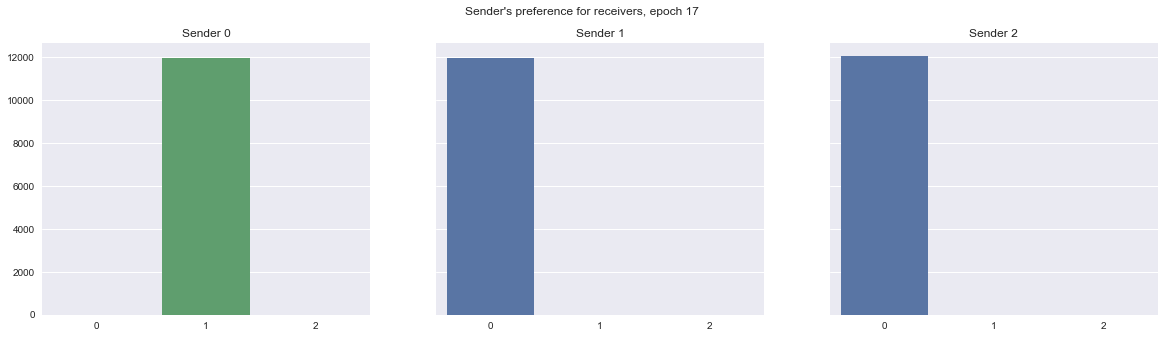

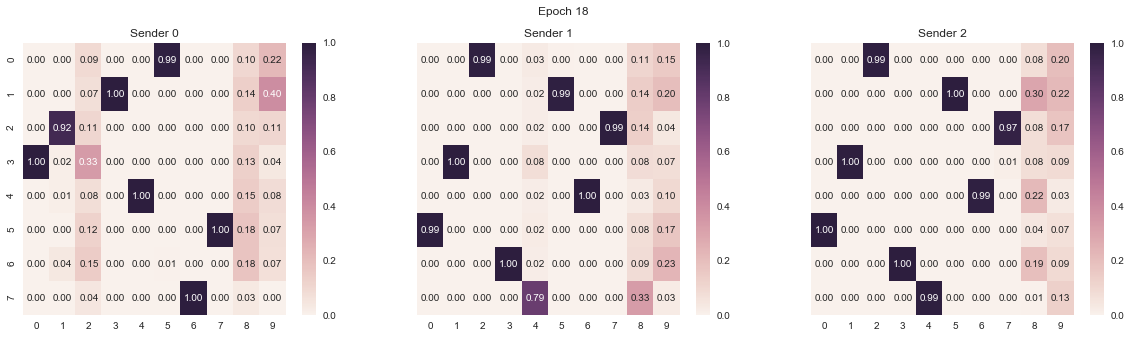

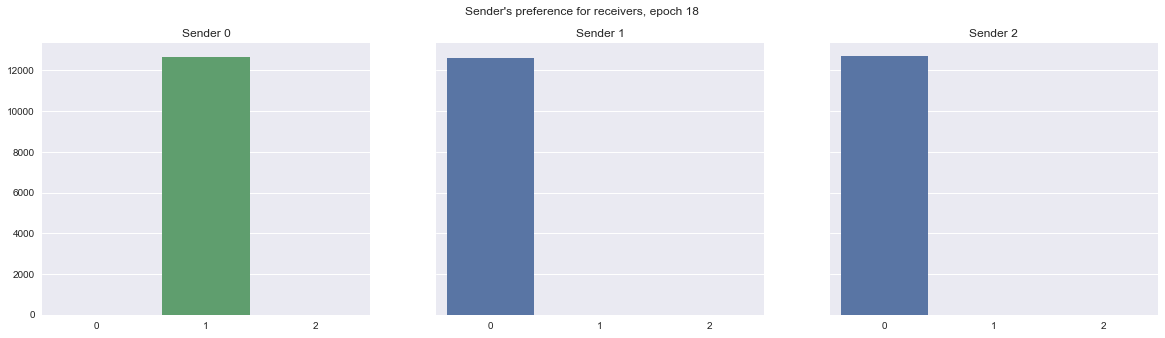

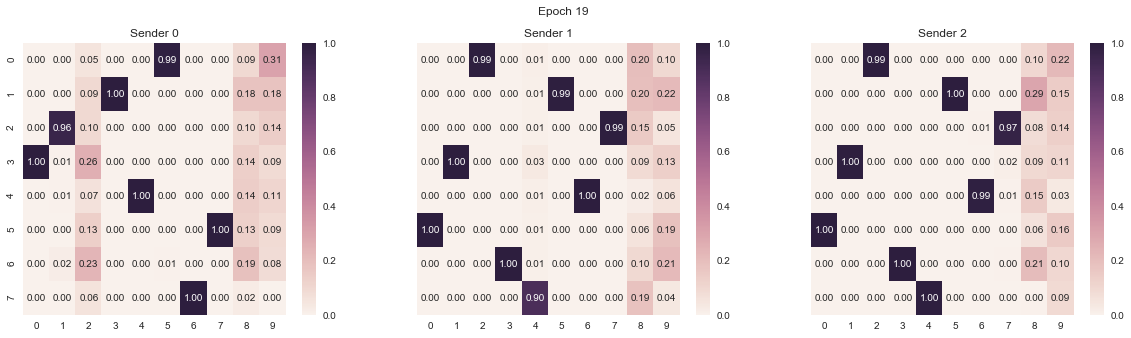

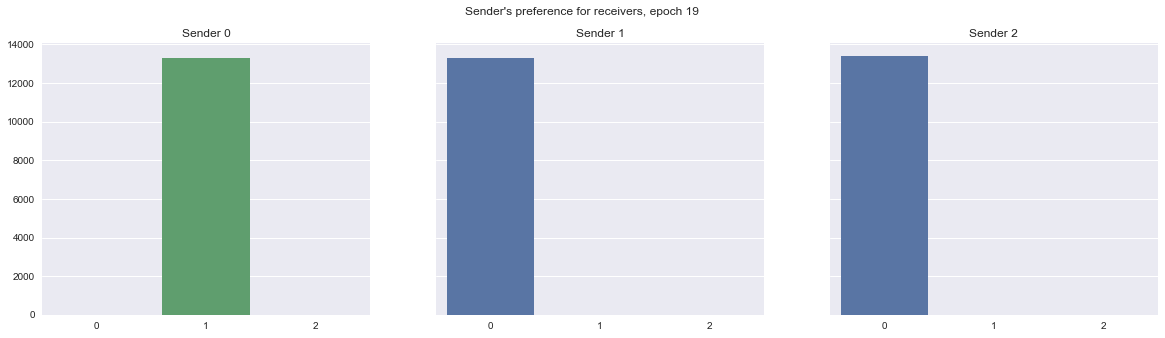

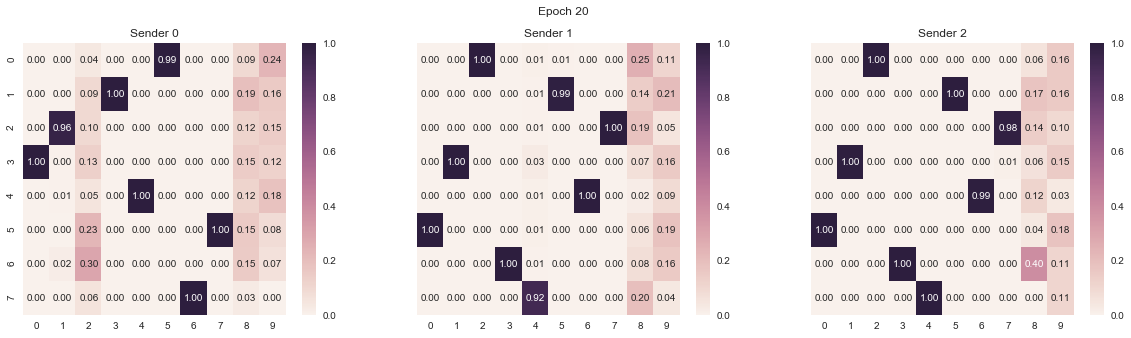

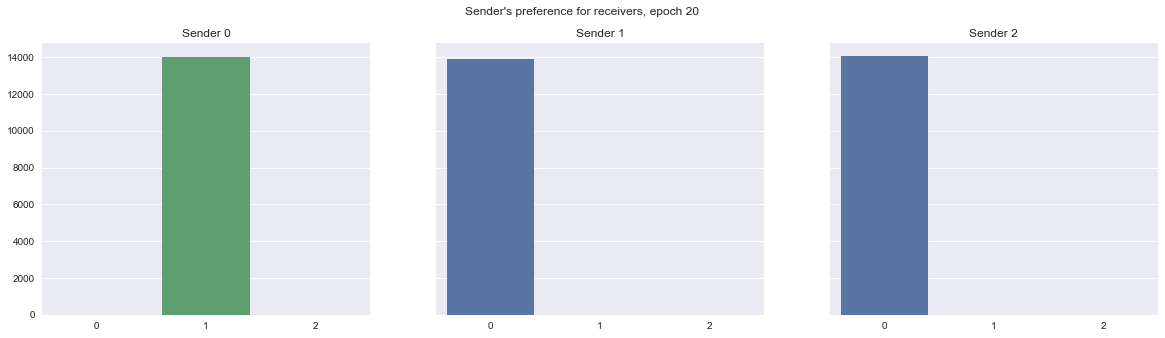

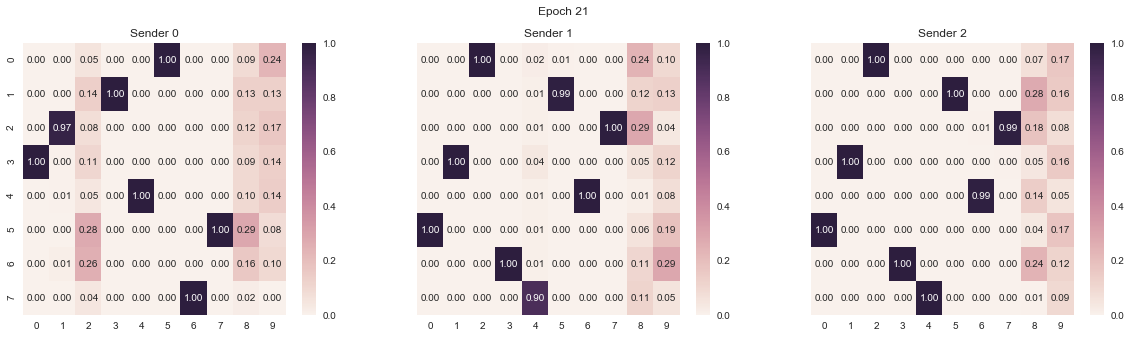

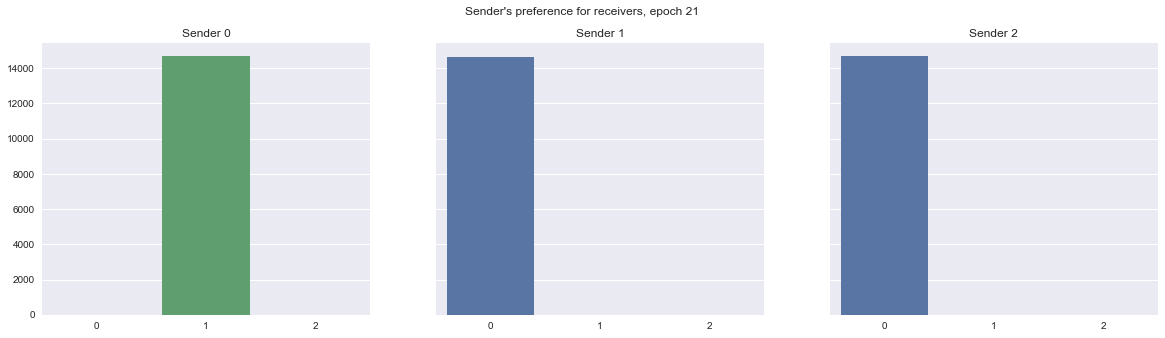

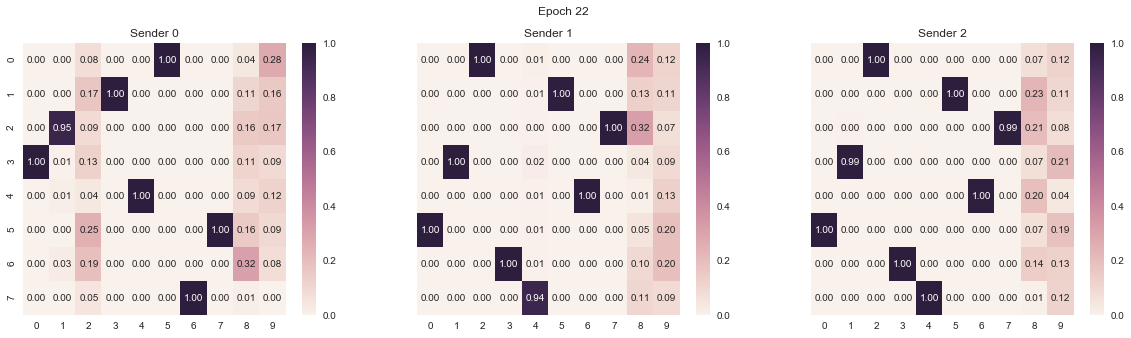

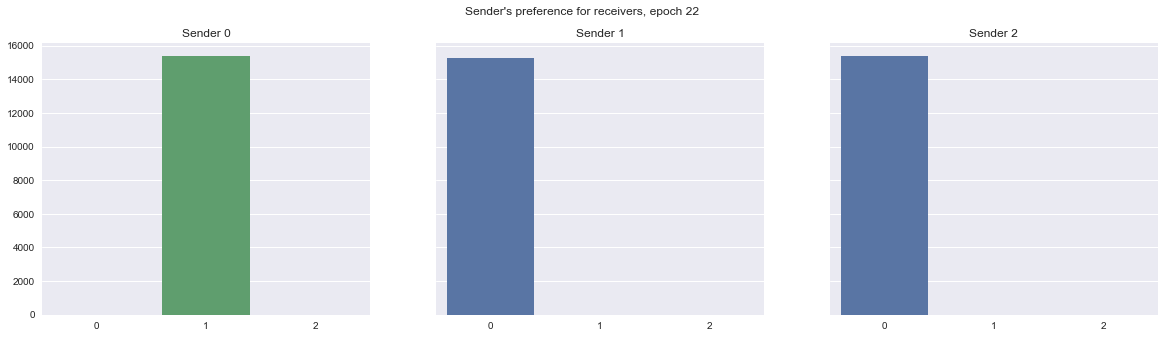

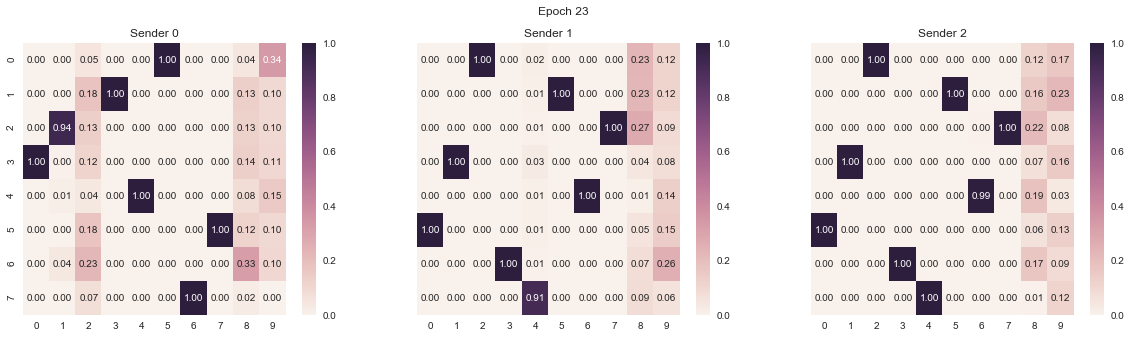

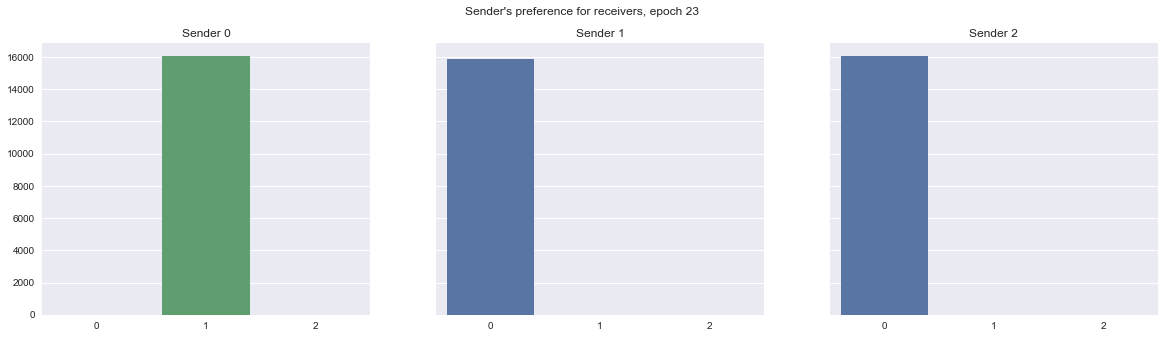

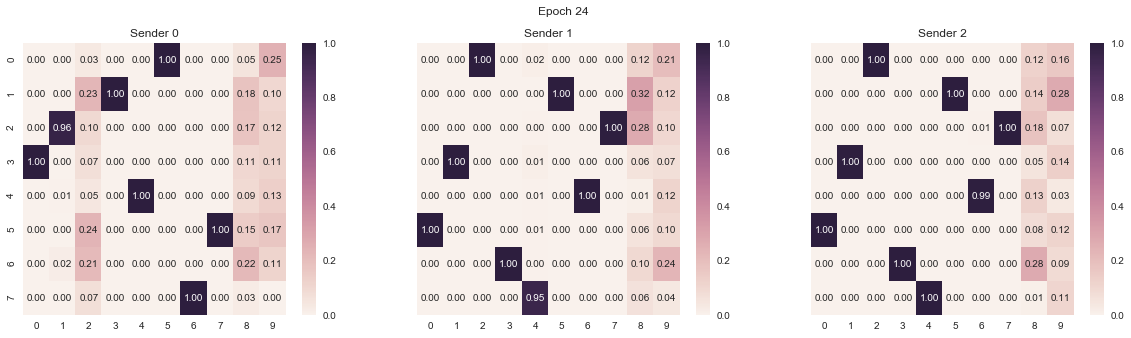

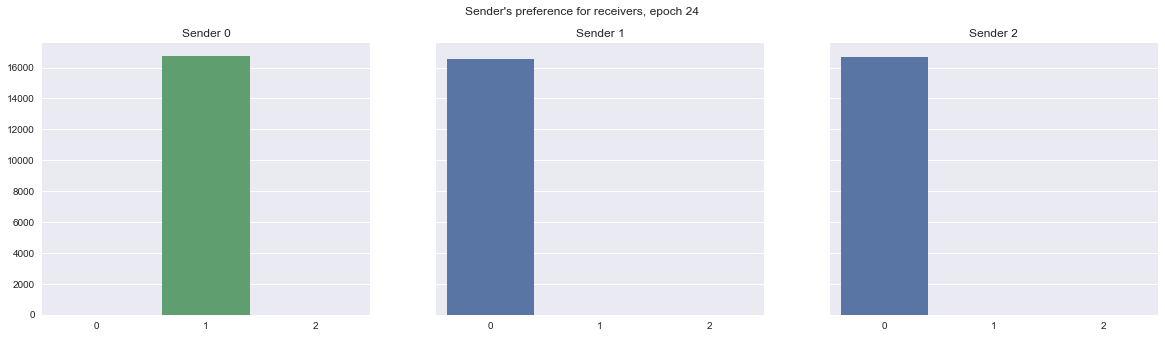

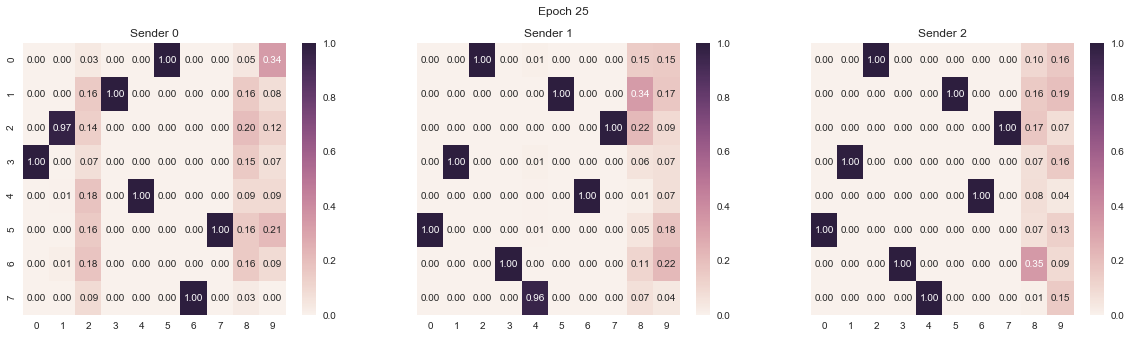

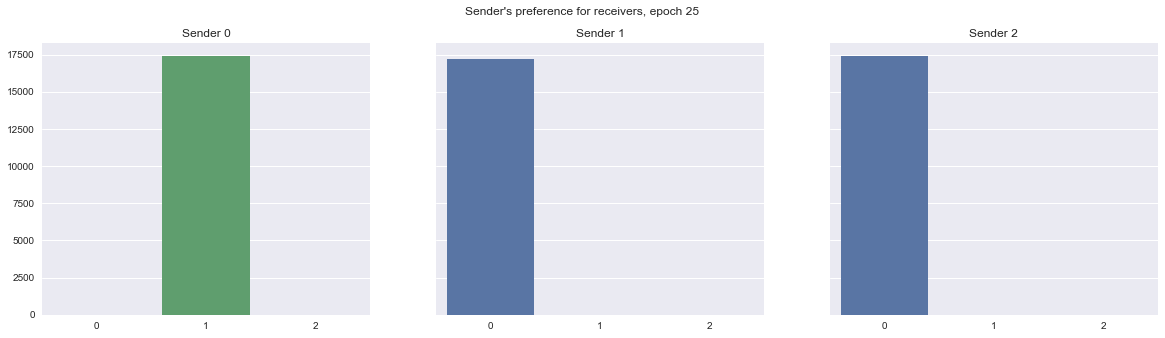

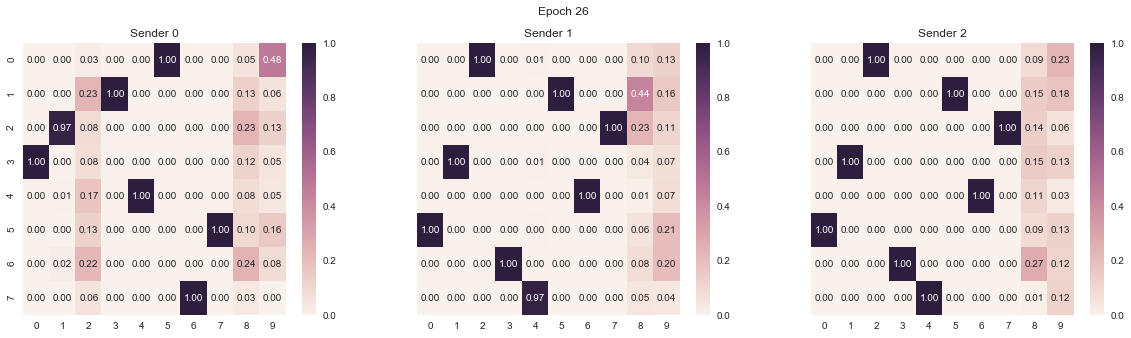

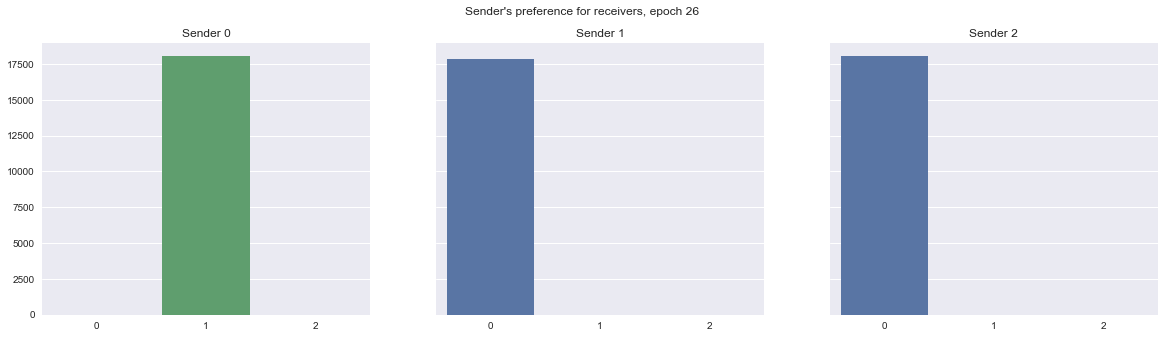

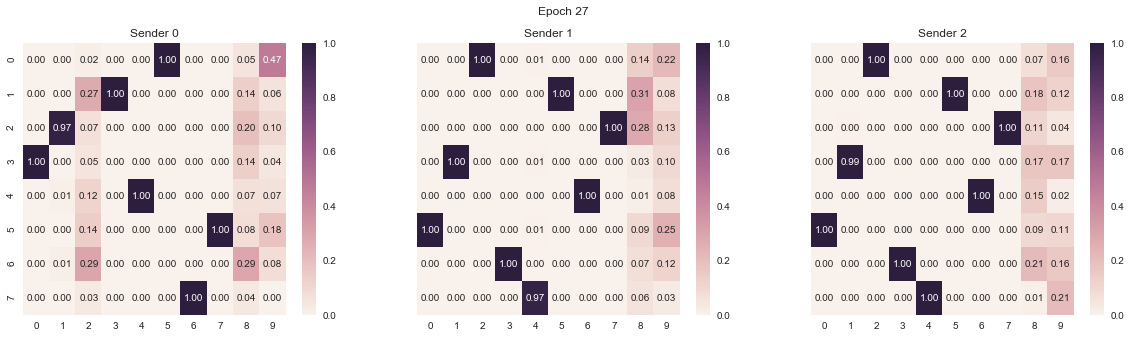

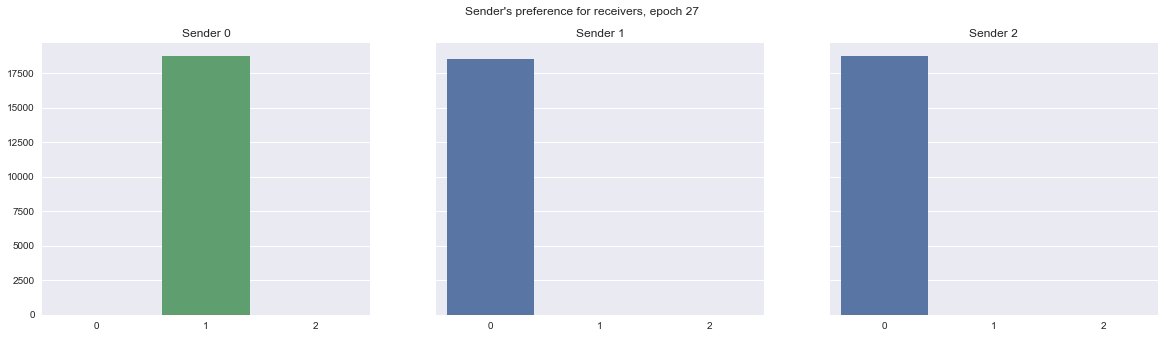

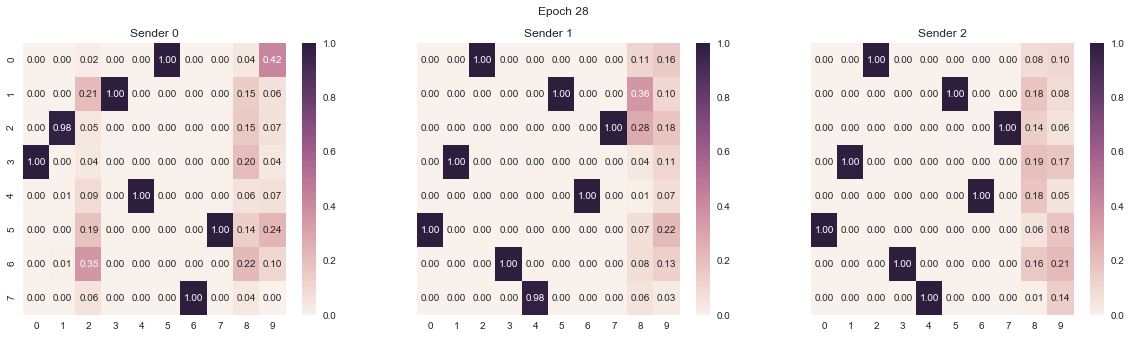

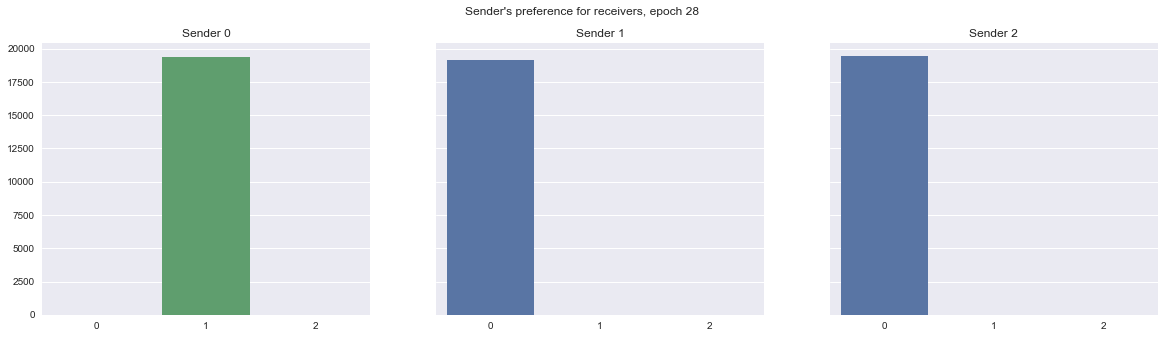

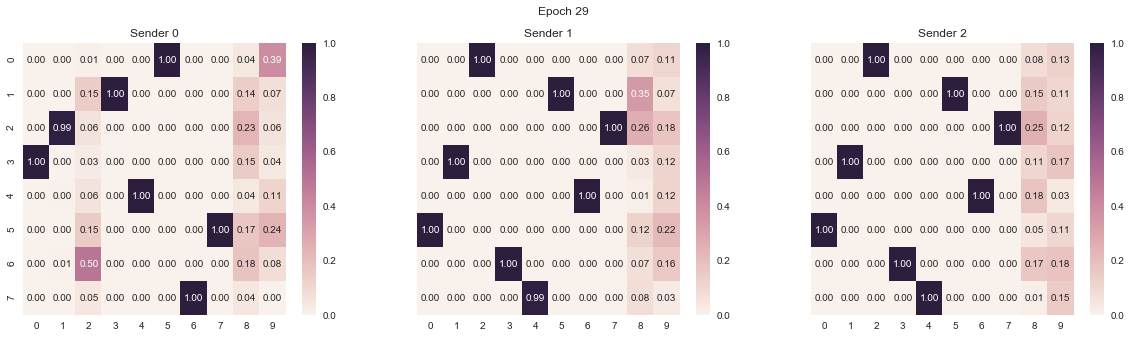

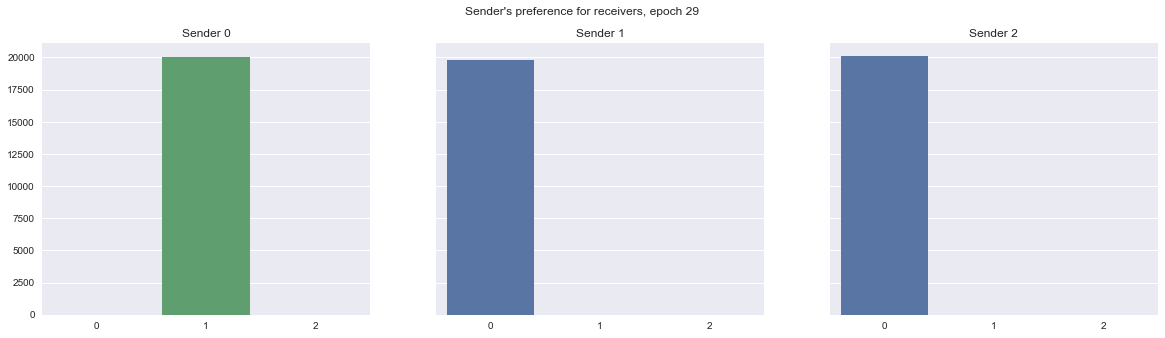

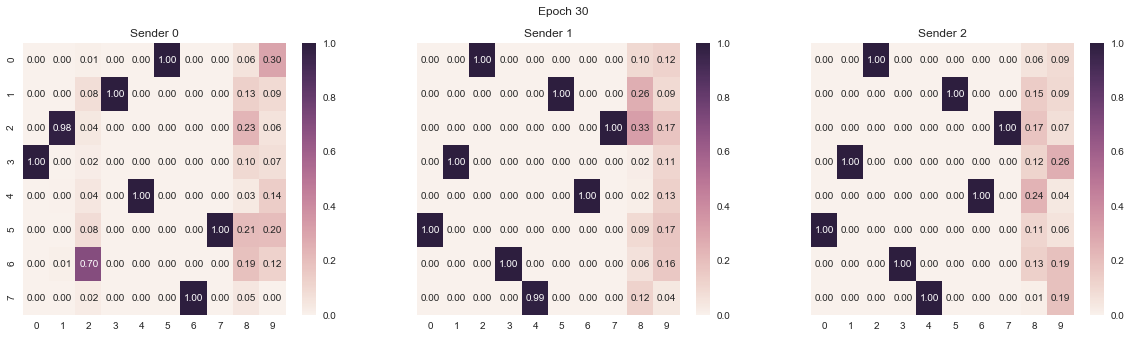

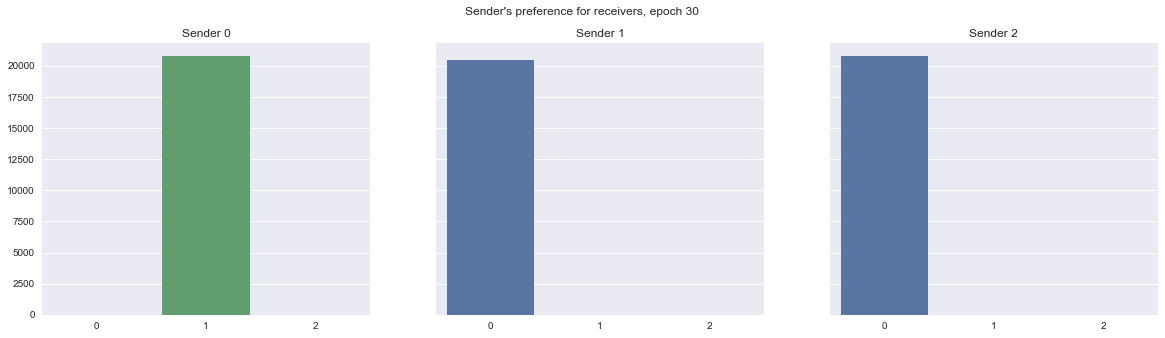

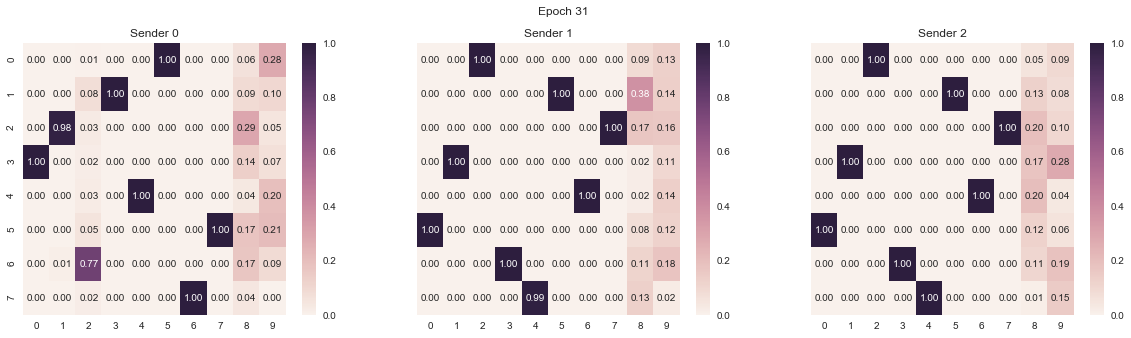

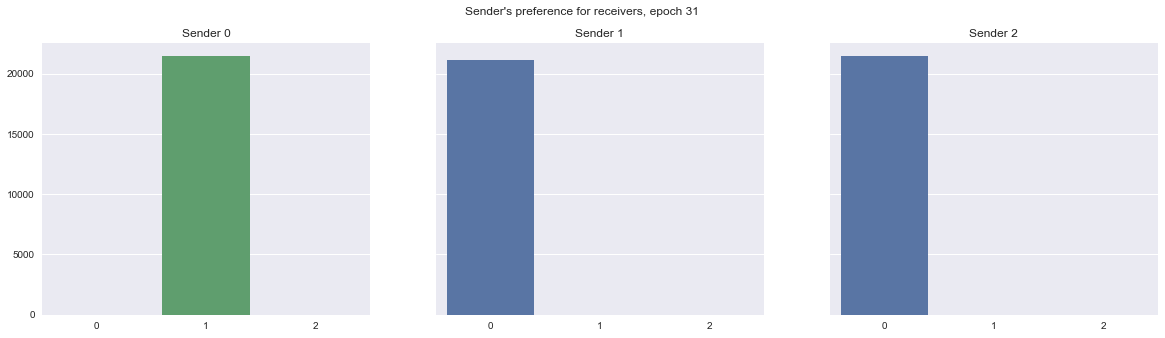

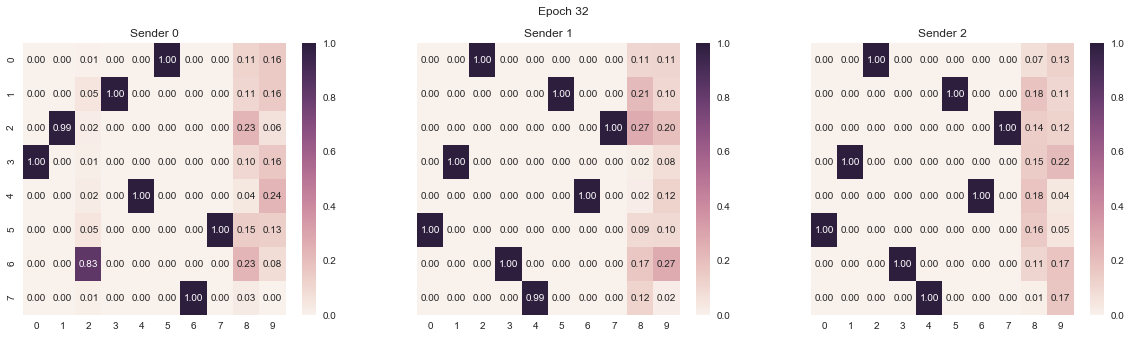

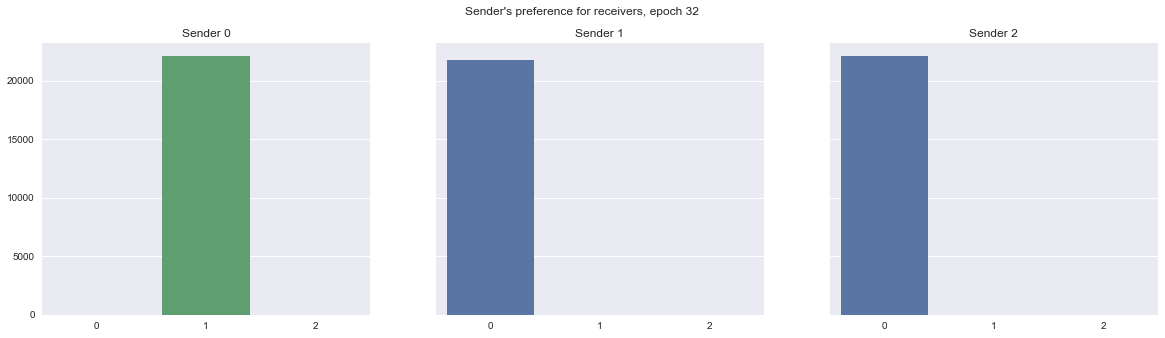

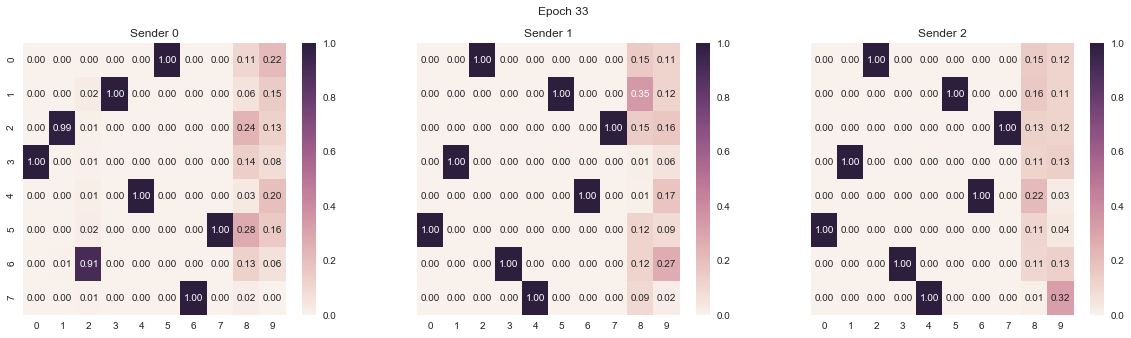

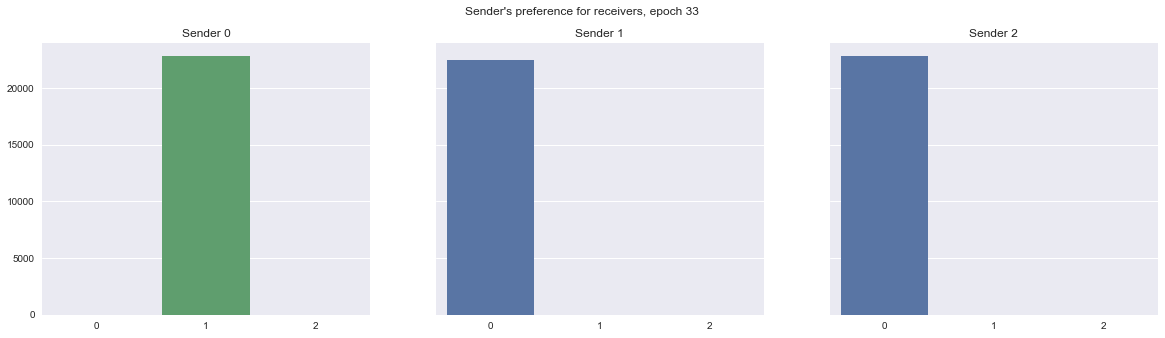

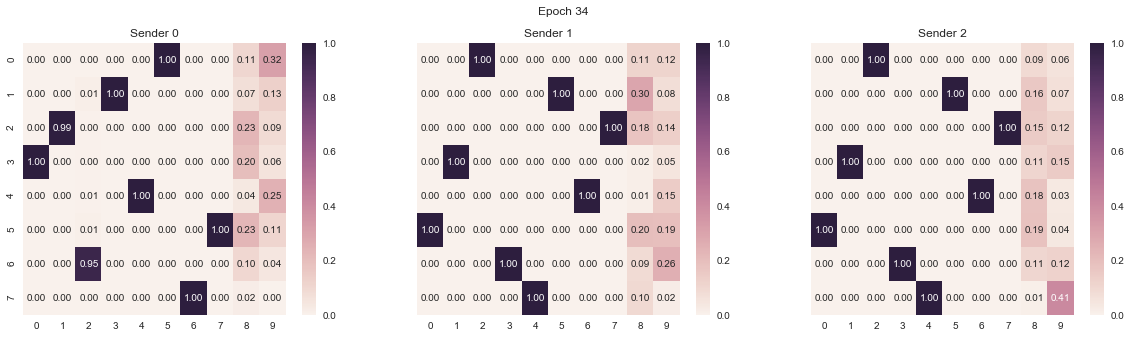

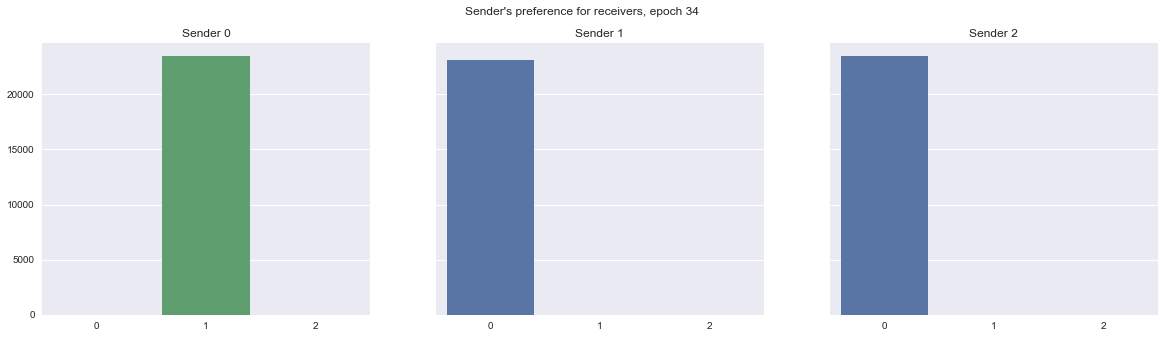

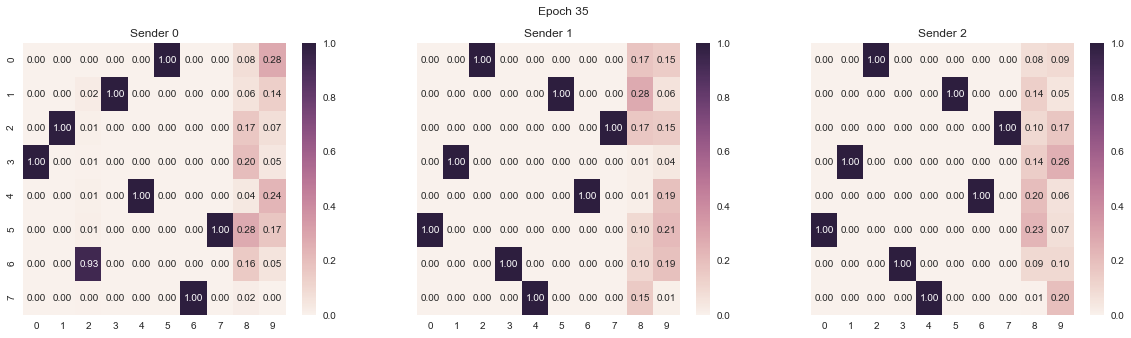

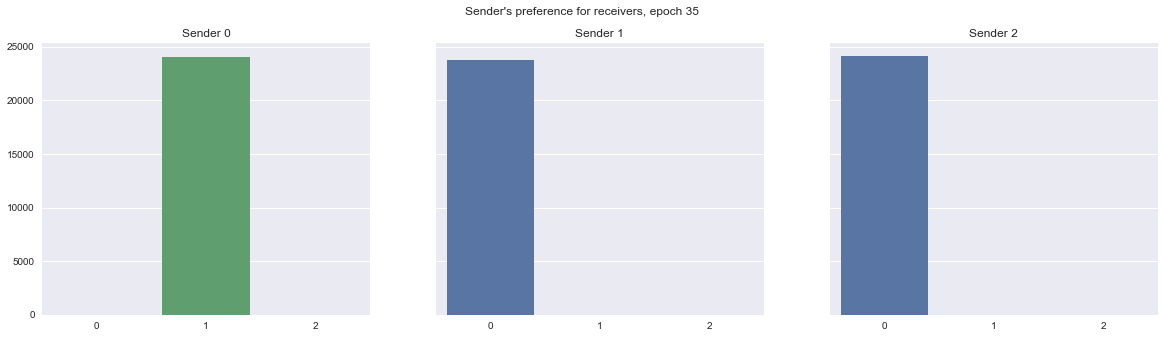

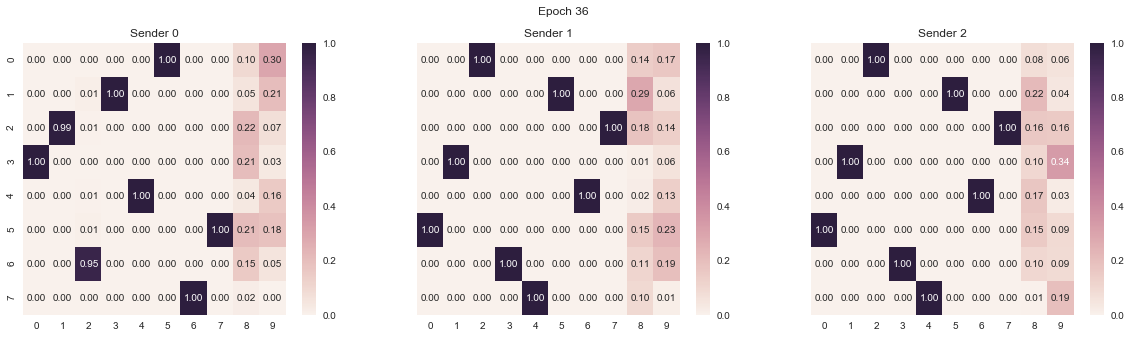

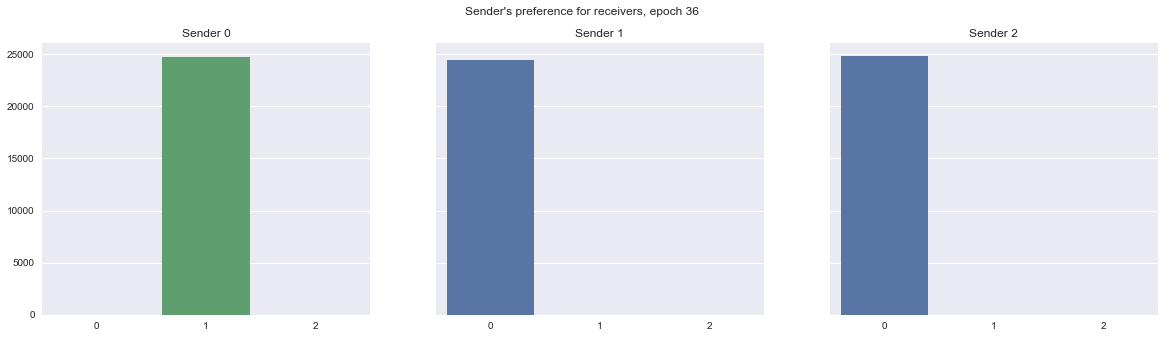

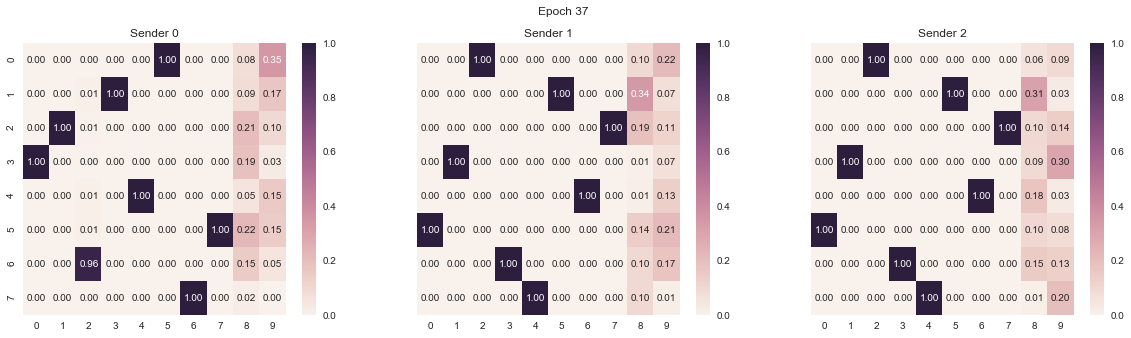

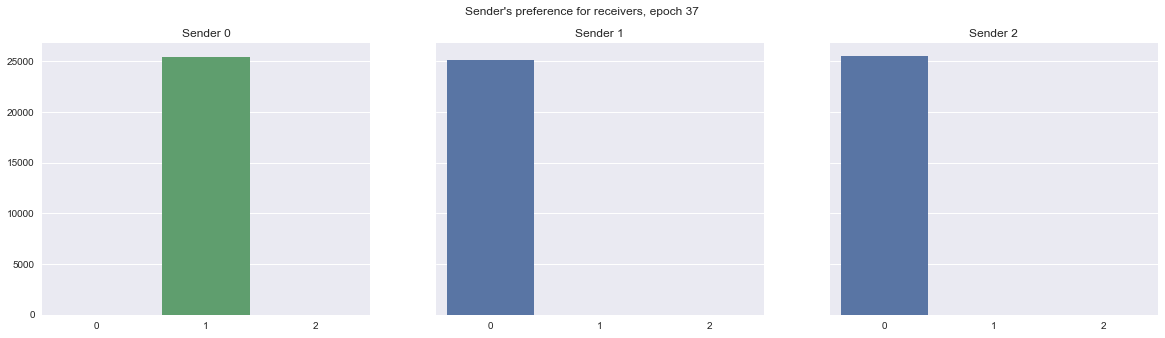

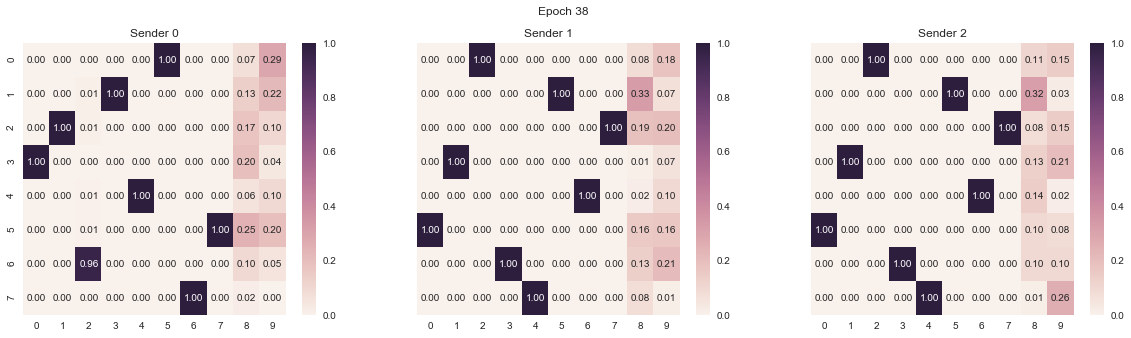

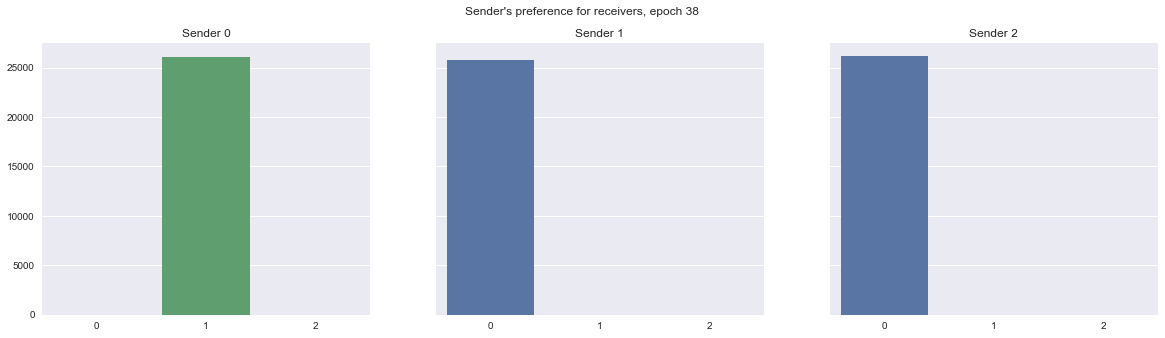

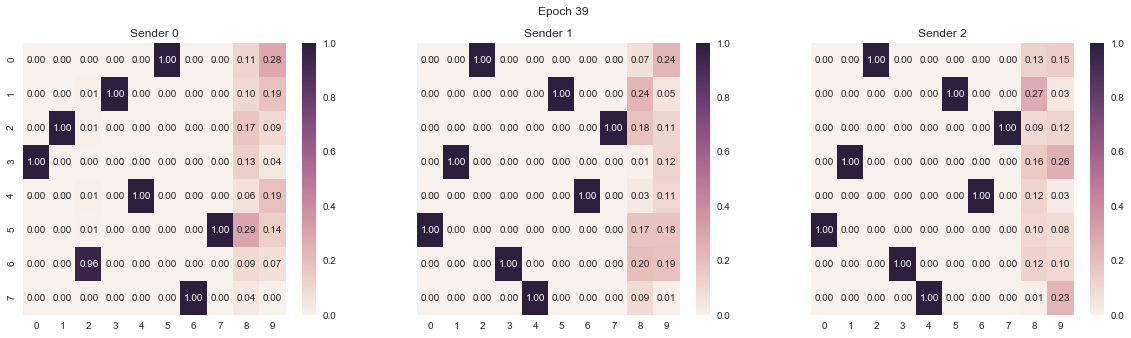

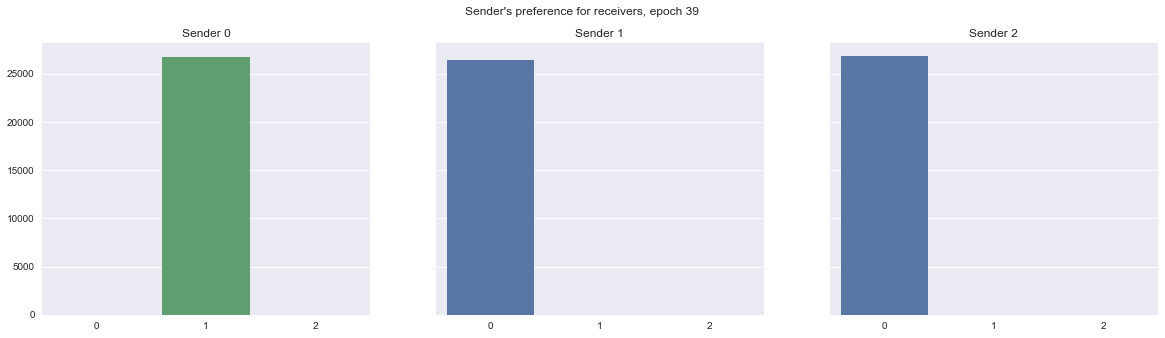

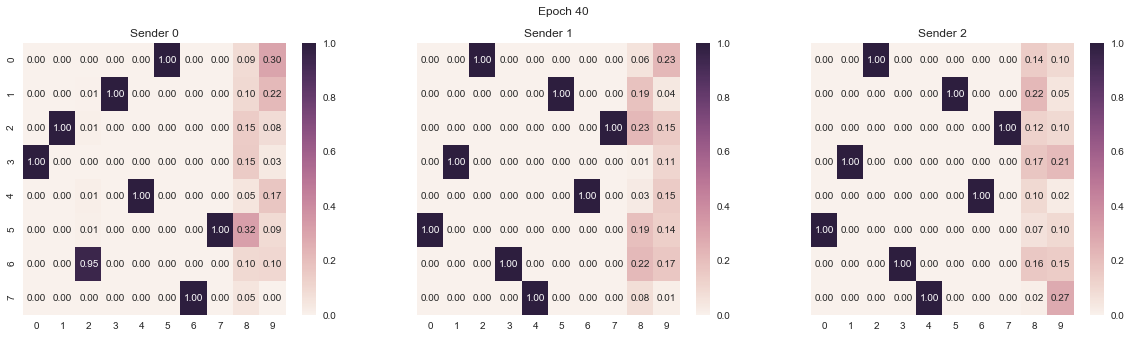

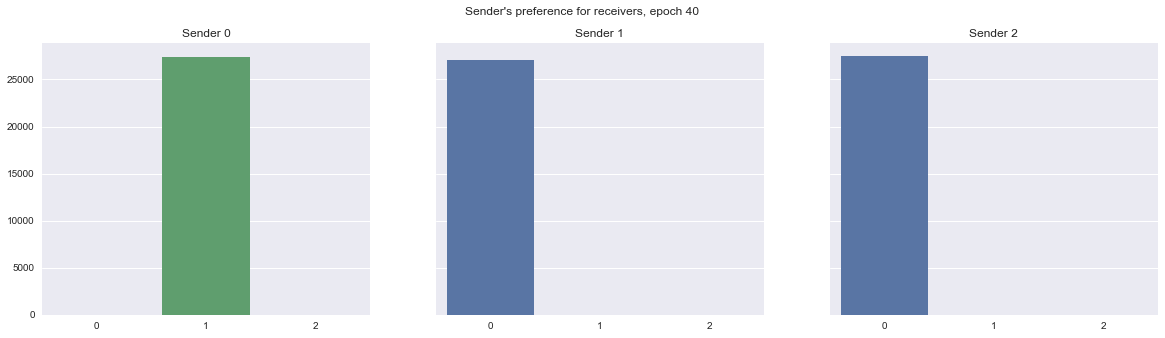

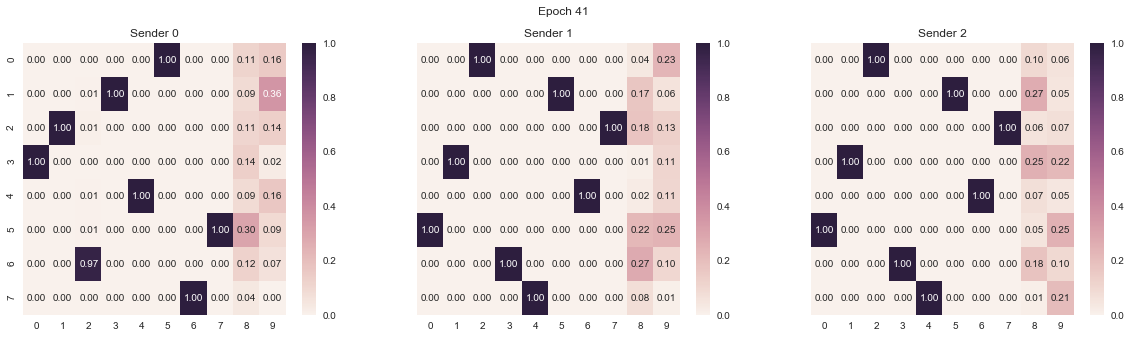

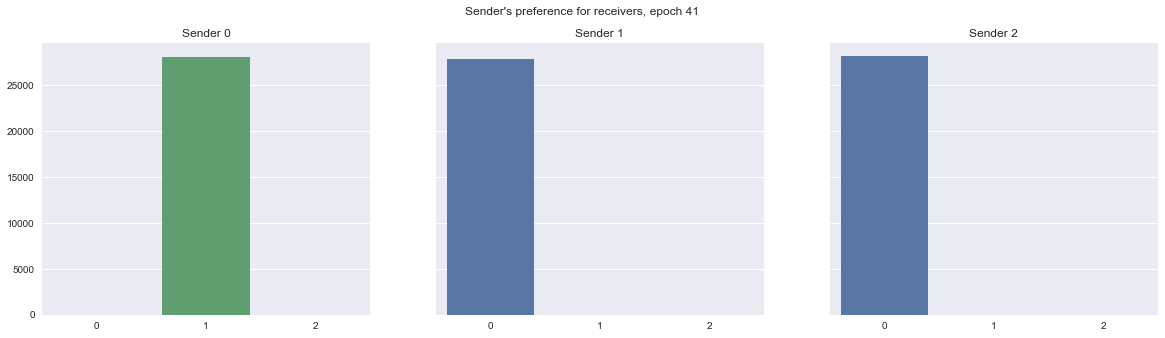

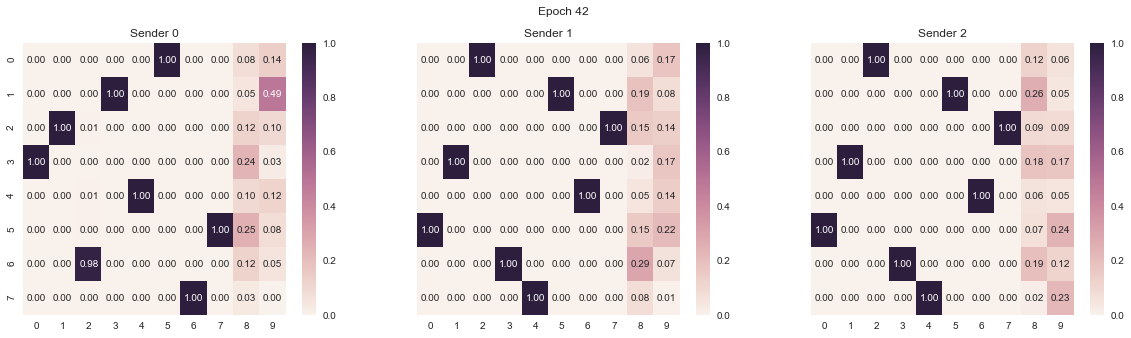

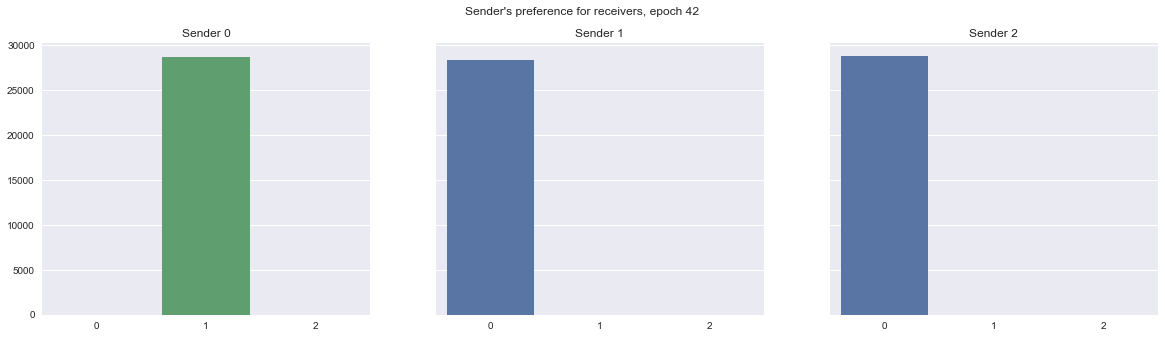

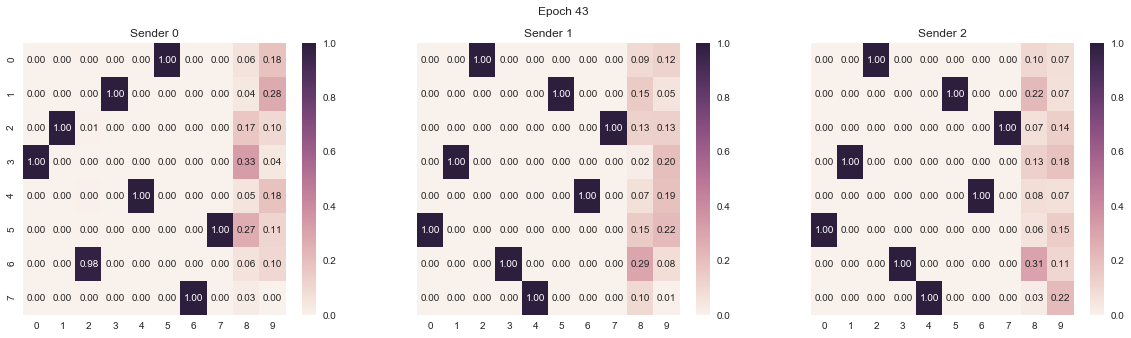

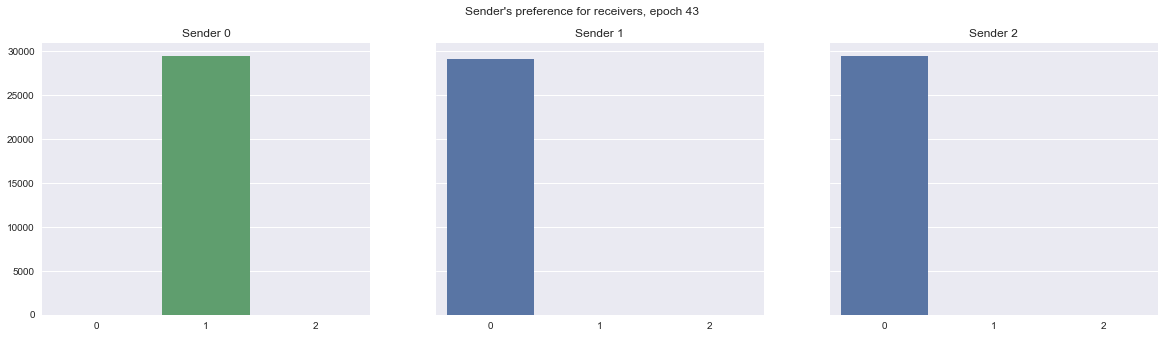

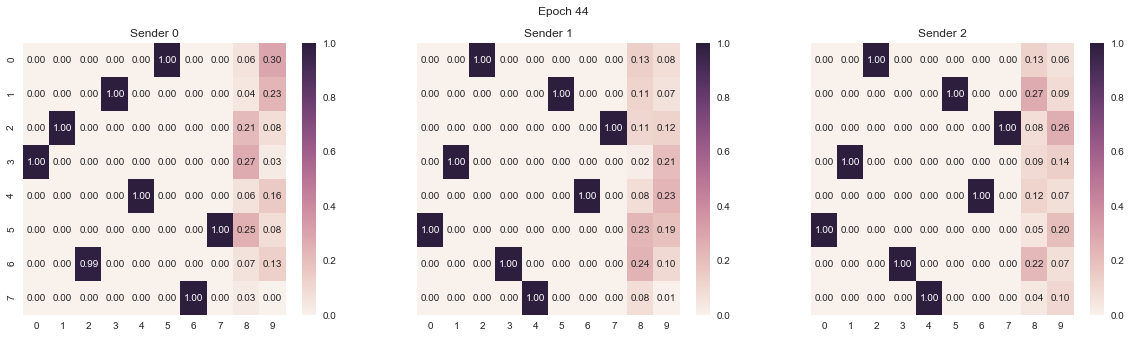

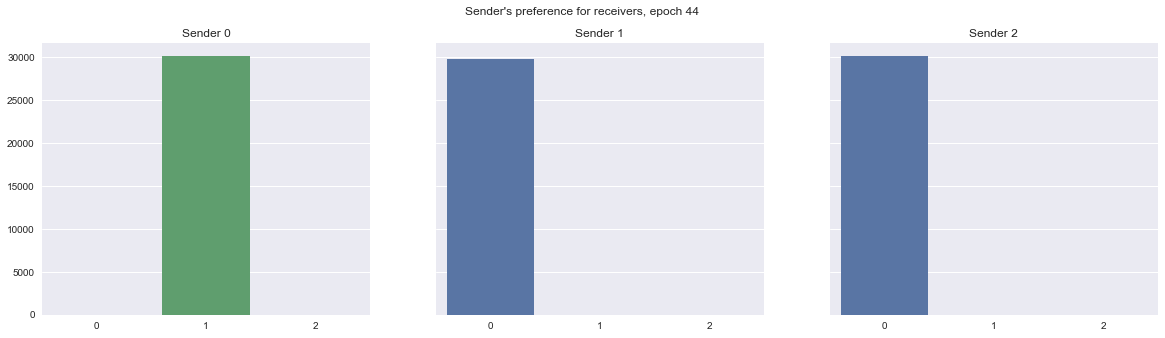

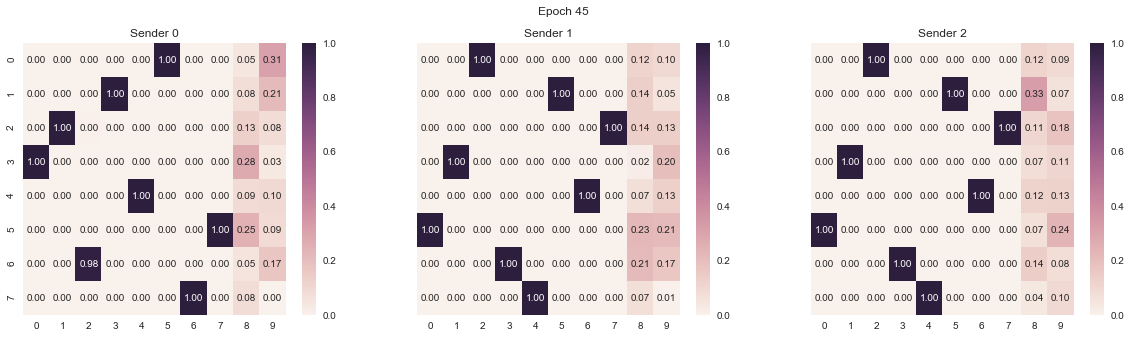

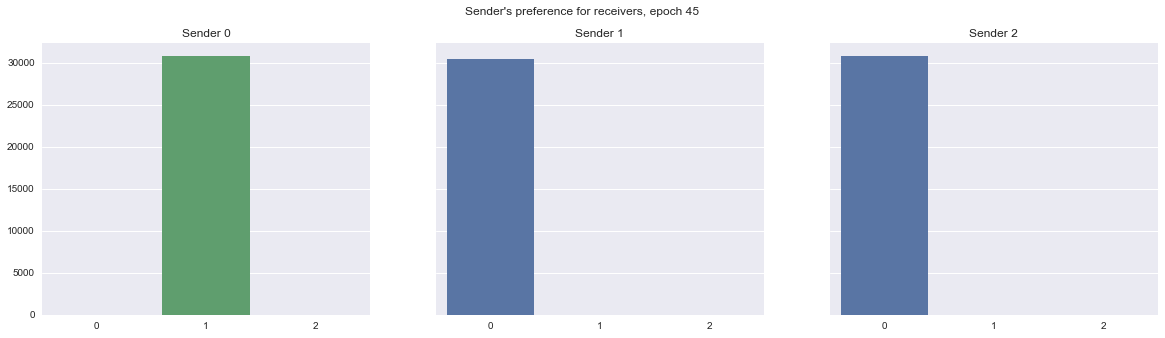

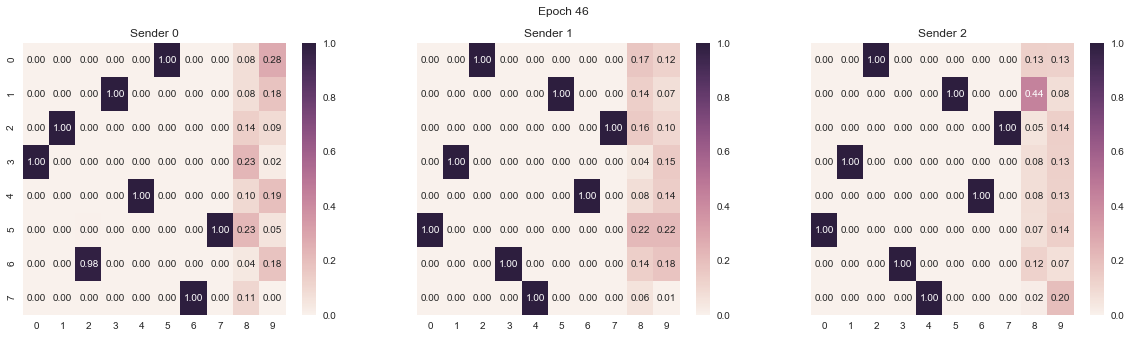

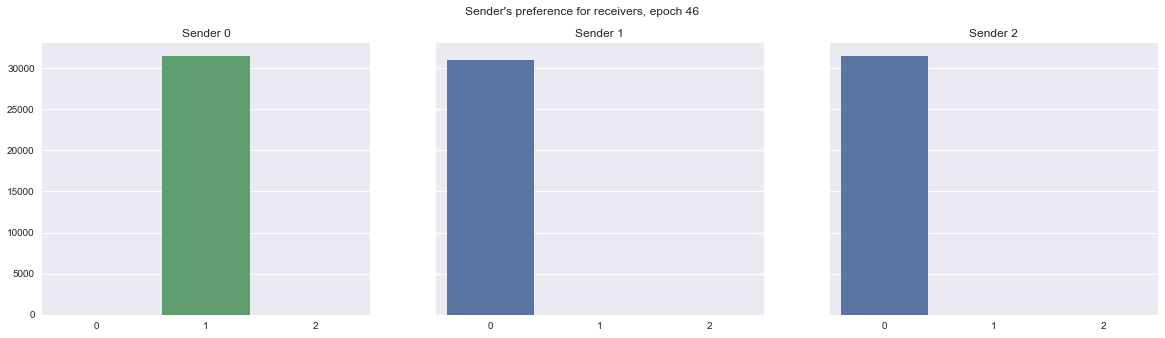

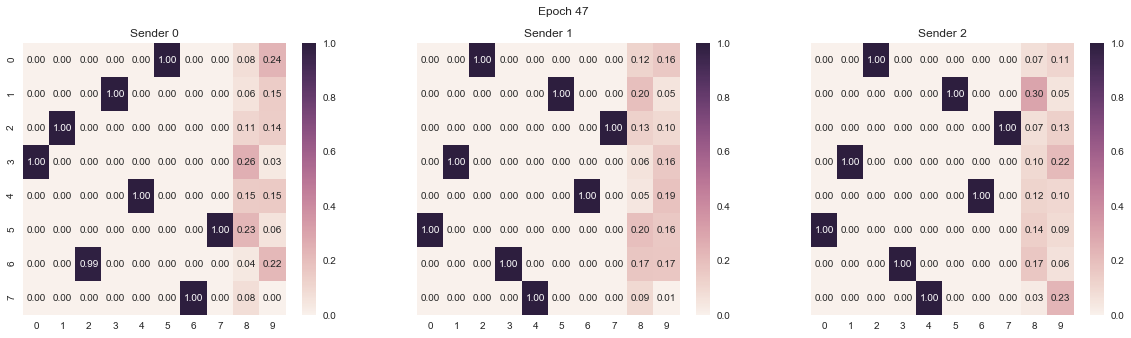

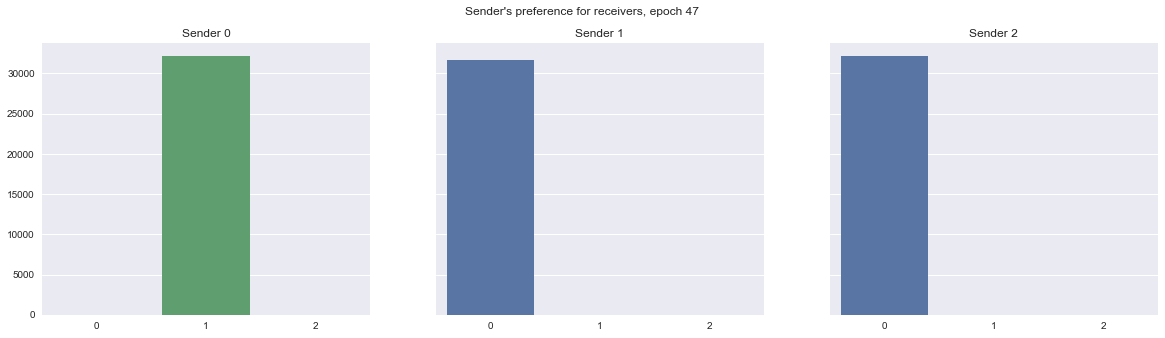

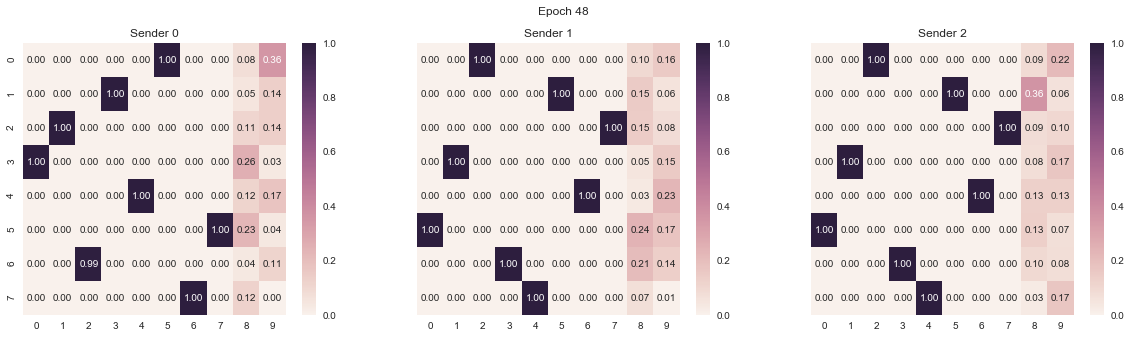

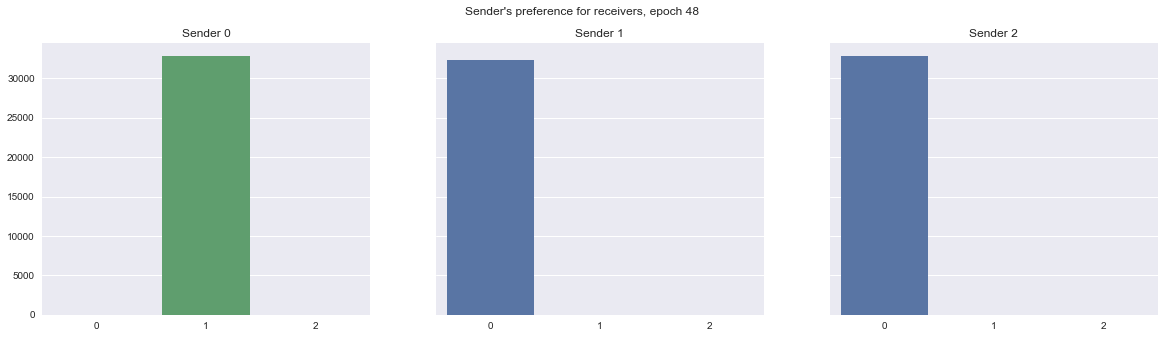

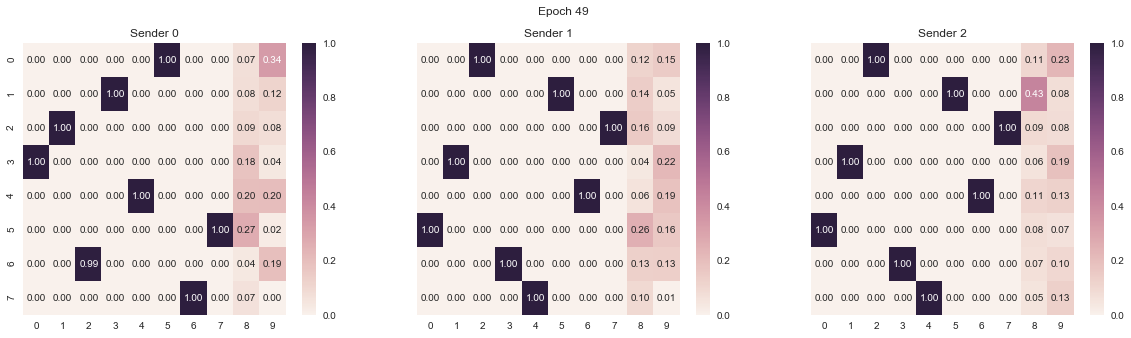

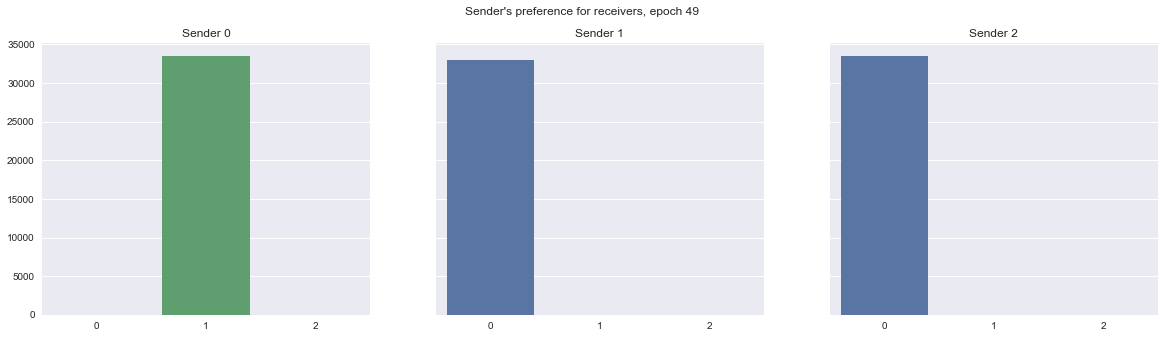

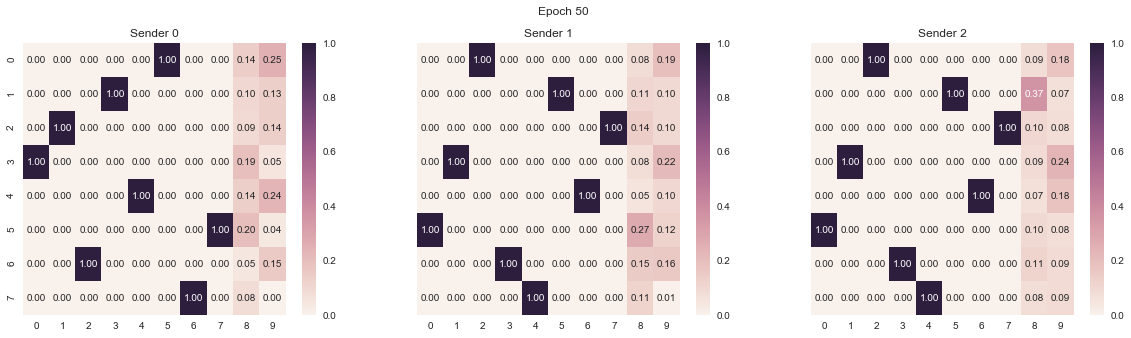

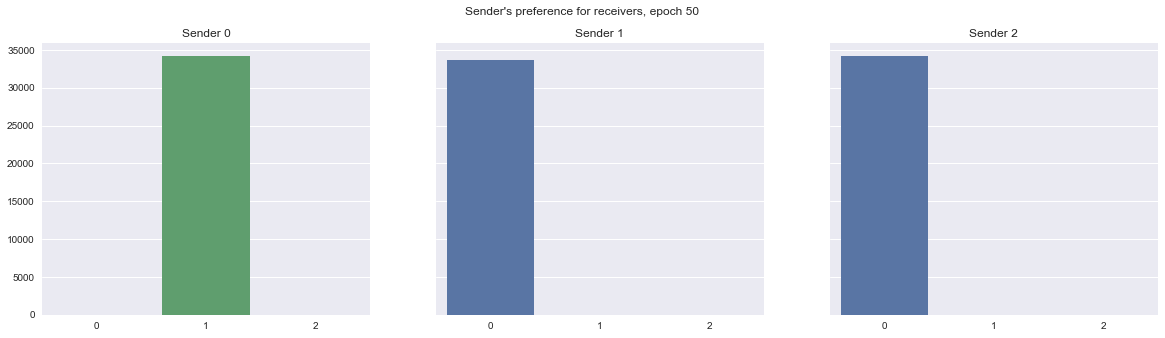

In [14]:
game = MultiAgentGame(senders, receivers, loss)
sender_params = [{'params': sender.parameters(), 'lr': opts.lr} for sender in senders]
receiver_params = [{'params': receiver.parameters(), 'lr': opts.lr} for receiver in receivers]
optimizer = torch.optim.Adam(sender_params+receiver_params)
neptune.init('tomekkorbak/EGG')
trainer = CustomTrainer(game=game, optimizer=optimizer, train_data=train_loader, validation_data=test_loader)
experiment = neptune.create_experiment(name='first-egg-experiment', tags=['egg', 'polya-urn-pairing'], params=vars(opts))
trainer.monitor = NeptuneMonitor(experiment=experiment)
trainer.train(n_epochs=opts.n_epochs)

In [16]:
experiment.stop()